In [1]:
%matplotlib inline
import gc

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn
from torchsummary import summary

import util
import audio_ss_dataset
import base_nnio
import mag_nnio
import models.base_models

torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

print(device)



cuda


# Load Dataset

In [2]:
num_sources = 2

sr, duration = 8000, 2.0

np.random.seed(0)
source1 = np.load(f'datasets/voices_sr{sr}_dur{duration}.npy')
np.random.shuffle(source1)
source1 = torch.from_numpy(source1)

np.random.seed(0)
source2 = 0.5 * np.load(f'datasets/air_conditioning_sr{sr}_dur{duration}_num15000.npy')
np.random.shuffle(source2)
source2 = torch.from_numpy(source2)

audiossds_test = audio_ss_dataset.AudioSSDS(sr, duration, sources=(source1[:100], source2[:100]))
audiossds_train = audio_ss_dataset.AudioSSDS(sr, duration, sources=(source1[100:], source2[100:]))
# audionnio = base_nnio.BaseNNIO(sr, duration, normalized=True, magphase_representation=True)
audionnio = mag_nnio.MagNNIO(sr, duration, normalized=True)


x, y = audiossds_test[:1]
input_shape, output_shape = audionnio.audio_to_nn_input(x)[0].shape, audionnio.audio_to_nn_output(y).shape
print('nn input shape: ', input_shape)
print('nn output shape: ', output_shape)

nn input shape:  torch.Size([1, 1, 151, 214])
nn output shape:  torch.Size([1, 1, 151, 214])


# Manual Method
Seperating the frequency manually from spectrogram

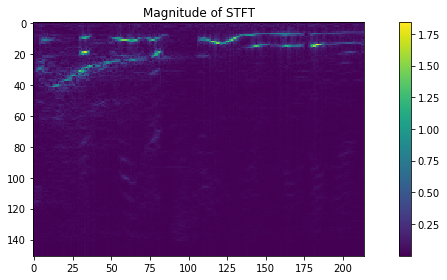

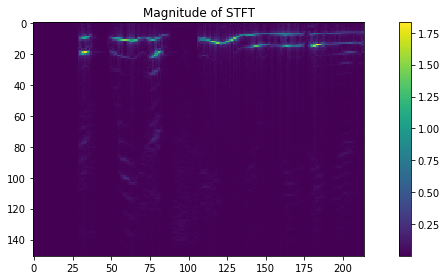

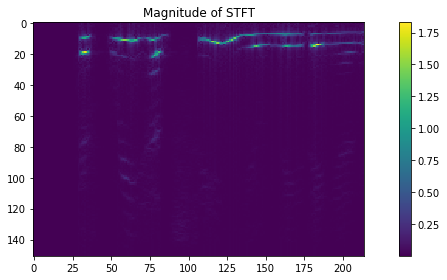

In [3]:
sample_idx = 4

X_test, Y_test = audiossds_test[::10]

audionnio.show_play_audio(X_test[sample_idx], ['mag', 'audio'])

audionnio.show_play_audio(Y_test[sample_idx, 0], ['mag', 'audio'])

X_test, X_test_phase = audionnio.audio_to_nn_input(X_test)
Y_test = audionnio.audio_to_nn_output(Y_test)

audionnio.show_play_nn_output(Y_test, X_test, X_test_phase, True, ['mag','audio'], sample_idx)


# Model Definitions

In [4]:
model_g = models.base_models.FTCNNGenerator(input_shape[0], [12, 12, 12 ,12 ,12 ,12], 
                         num_layers_per_block=4, block_gr=24).to(device, dtype)
# model_g = torch.load('models/ftnn_naive_epochs300.pth')
summary(model_g, input_size=input_shape[1:])

model_d = models.base_models.FTCNNDiscrimminator(input_shape[0], [6, 6, 6, 6], input_hw = input_shape[2:], 
                              num_layers_per_block=4, block_gr=24).to(device, dtype)
summary(model_d, input_size=input_shape[1:])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 151, 214]              24
       BatchNorm2d-2         [-1, 12, 151, 214]              24
              ReLU-3         [-1, 12, 151, 214]               0
            Conv2d-4         [-1, 24, 151, 214]           2,616
       BatchNorm2d-5         [-1, 36, 151, 214]              72
              ReLU-6         [-1, 36, 151, 214]               0
            Conv2d-7         [-1, 24, 151, 214]           7,800
       BatchNorm2d-8         [-1, 60, 151, 214]             120
              ReLU-9         [-1, 60, 151, 214]               0
           Conv2d-10         [-1, 24, 151, 214]          12,984
      BatchNorm2d-11         [-1, 84, 151, 214]             168
             ReLU-12         [-1, 84, 151, 214]               0
           Conv2d-13         [-1, 12, 151, 214]           9,084
  NeuralTransform-14         [-1, 12, 1

# Base Method

Make a neural network to just take out the tone

In [14]:
mse = nn.MSELoss()
bce = nn.BCELoss()

import pytorch_ssim

lambda_mse = 1e2
lambda_noise_weighted_mse = 1e4
lambda_ssim = 0.0

def generator_loss_function_base(Y_batch_pred, Y_batch, X_batch):
    # normal MSE loss for now
    Y_batch_noise = X_batch-Y_batch
    Y_batch_noise_pred = X_batch-Y_batch_pred
    
    # normal mse loss
    loss_mse = lambda_mse * mse(Y_batch_pred, Y_batch)
    
    # noise weighted mse loss
    loss_noise_weighted_mse = lambda_noise_weighted_mse * torch.mean(((Y_batch_pred-Y_batch)**2) * torch.abs(Y_batch_noise))
    
    # SSIM loss
    loss_ssim = lambda_ssim * (2 - pytorch_ssim.ssim(Y_batch, Y_batch_pred) - pytorch_ssim.ssim(Y_batch_noise, Y_batch_noise_pred))
    
    # total loss
    loss = loss_mse + loss_noise_weighted_mse + loss_ssim
    print(f'{loss_mse}+{loss_noise_weighted_mse}+{loss_ssim}={loss}')
    
    return loss

In [15]:
X_test, Y_test = audiossds_test[:50]
X_test, Y_test = audionnio.audio_to_nn_input(X_test), audionnio.audio_to_nn_output(Y_test)
X_test, X_test_phase = X_test
print(X_test.shape)
print(Y_test.shape)

torch.Size([50, 1, 151, 214])
torch.Size([50, 1, 151, 214])


In [16]:
with torch.no_grad():
    Y_test_pred = model_g(X_test.to(device,dtype)).cpu()

print('Test Loss: ', generator_loss_function_base(Y_test_pred, Y_test, X_test).item())


4.68005895614624+10.657539367675781+0.0=15.33759880065918
Test Loss:  15.33759880065918


Showing example:  30
Input:


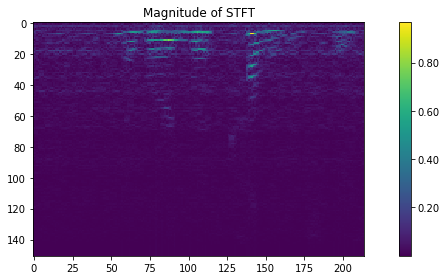

Target:


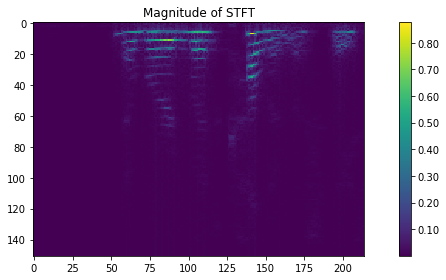

Output:


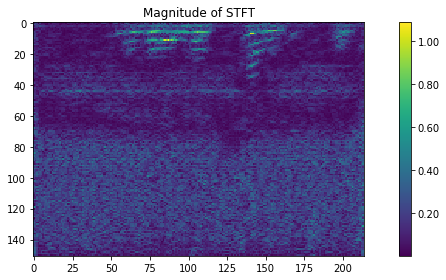

In [17]:
test_example_idx = 30
print('Showing example: ', test_example_idx)
print('Input:')
audionnio.show_play_nn_input(X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Target:')
audionnio.show_play_nn_output(Y_test, X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Output:')
audionnio.show_play_nn_output(Y_test_pred, X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)

In [18]:
util.clear_mem(True)

total:  11.996954624
cached:  0.037748736
allocated:  0.010331648


4.462331771850586+9.471083641052246+0.0=13.933415412902832
32.779632568359375+71.97208404541016+0.0=104.75171661376953
7.959225177764893+5.0766377449035645+0.0=13.035862922668457
5.050574779510498+7.903678894042969+0.0=12.954254150390625
12.810718536376953+26.570140838623047+0.0=39.380859375
10.192045211791992+1.2549309730529785+0.0=11.446975708007812
5.324012279510498+2.867511034011841+0.0=8.191523551940918
1.8110910654067993+2.7479612827301025+0.0=4.559052467346191
4.198432445526123+1.9600831270217896+0.0=6.158515453338623
8.071891784667969+5.193337440490723+0.0=13.265229225158691
6.467195510864258+4.844433307647705+0.0=11.311628341674805
2.6224145889282227+0.6041792035102844+0.0=3.2265937328338623
0.7114326357841492+3.1318702697753906+0.0=3.8433029651641846
1.3978374004364014+2.404139280319214+0.0=3.8019766807556152
2.7589478492736816+1.4452667236328125+0.0=4.204214572906494
3.5290017127990723+3.5716609954833984+0.0=7.100662708282471
2.5546905994415283+1.2700272798538208+0.0=3.82471

1.65023672580719+1.6114256381988525+0.0=3.261662483215332
1.875304102897644+1.6410778760910034+0.0=3.5163819789886475
1.5638298988342285+1.4397519826889038+0.0=3.003582000732422
0.7359755039215088+0.35628747940063477+0.0=1.0922629833221436
0.3256618082523346+0.8066028356552124+0.0=1.1322646141052246
0.45951399207115173+0.33279916644096375+0.0=0.7923131585121155
0.757204532623291+0.3387489914894104+0.0=1.0959534645080566
0.8655675649642944+1.4581842422485352+0.0=2.323751926422119
0.8549286723136902+5.71226167678833+0.0=6.567190170288086
0.4858396053314209+2.7964463233947754+0.0=3.2822859287261963
0.25937244296073914+0.4973211884498596+0.0=0.7566936016082764
0.507839560508728+0.5531371235847473+0.0=1.0609767436981201
0.9810812473297119+1.0830585956573486+0.0=2.0641398429870605
1.175339698791504+2.0275723934173584+0.0=3.2029120922088623
0.8582035899162292+1.203260898590088+0.0=2.061464548110962
0.9382065534591675+2.397324323654175+0.0=3.3355307579040527
0.5614241361618042+2.35297298431396

0.4933421015739441+0.8100524544715881+0.0=1.3033945560455322
0.33905085921287537+1.2964116334915161+0.0=1.6354625225067139
0.257982462644577+0.38098108768463135+0.0=0.6389635801315308
0.35268208384513855+2.9980671405792236+0.0=3.3507492542266846
0.36585184931755066+1.7519906759262085+0.0=2.117842435836792
0.477809876203537+0.8121885657310486+0.0=1.2899984121322632
0.6453099250793457+1.1113979816436768+0.0=1.7567079067230225
0.6622392535209656+1.2317538261413574+0.0=1.8939931392669678
0.4142328202724457+1.0321766138076782+0.0=1.4464094638824463
0.49773189425468445+0.4895314574241638+0.0=0.9872633218765259
0.5249936580657959+0.5576562285423279+0.0=1.0826499462127686
0.67398601770401+1.2641769647598267+0.0=1.9381630420684814
0.45044267177581787+0.4279433786869049+0.0=0.8783860206604004
0.43065720796585083+0.8430292010307312+0.0=1.273686408996582
0.3614676594734192+1.4754621982574463+0.0=1.8369297981262207
0.21553383767604828+0.707898736000061+0.0=0.9234325885772705
0.3414033353328705+1.50

0.2949218153953552+0.7938673496246338+0.0=1.0887892246246338
0.29145383834838867+1.4089112281799316+0.0=1.7003650665283203
0.23034678399562836+0.45750850439071655+0.0=0.6878553032875061
0.24608993530273438+0.7325476408004761+0.0=0.9786375761032104
0.20811480283737183+0.49073541164398193+0.0=0.6988502144813538
0.223152294754982+0.23807571828365326+0.0=0.46122801303863525
0.24958504736423492+0.7662981152534485+0.0=1.015883207321167
0.22327420115470886+0.32533931732177734+0.0=0.5486135482788086
0.22920207679271698+0.16809269785881042+0.0=0.3972947597503662
0.19377942383289337+0.32571685314178467+0.0=0.5194962620735168
0.19249305129051208+0.9295346736907959+0.0=1.1220277547836304
0.23584982752799988+1.4772000312805176+0.0=1.7130498886108398
0.3838576078414917+1.4247533082962036+0.0=1.8086109161376953
0.3623725473880768+0.5496496558189392+0.0=0.9120222330093384
0.2404215931892395+0.6859383583068848+0.0=0.9263599514961243
0.2860344350337982+0.3120846748352051+0.0=0.5981191396713257
0.2934380

0.18953651189804077+0.9039095044136047+0.0=1.0934460163116455
0.17026931047439575+0.6964120864868164+0.0=0.8666813969612122
0.17175105214118958+0.7580803036689758+0.0=0.9298313856124878
0.22911636531352997+0.26929640769958496+0.0=0.4984127879142761
0.27385184168815613+1.4988456964492798+0.0=1.7726975679397583
0.2829485535621643+0.7153682112693787+0.0=0.998316764831543
0.28126832842826843+0.7517293095588684+0.0=1.0329976081848145
0.19014139473438263+0.21435049176216125+0.0=0.4044919013977051
0.258522093296051+0.47113558650016785+0.0=0.7296576499938965
0.1343401074409485+0.410380095243454+0.0=0.5447201728820801
0.22818897664546967+0.922092854976654+0.0=1.1502817869186401
0.13583959639072418+0.5079905986785889+0.0=0.6438301801681519
0.1627415418624878+1.3145006895065308+0.0=1.4772422313690186
0.2045229822397232+0.43750977516174316+0.0=0.6420327425003052
0.2600107192993164+1.085052251815796+0.0=1.3450629711151123
0.4540518820285797+1.4849125146865845+0.0=1.9389643669128418
0.27501690387725

0.18214336037635803+0.34037500619888306+0.0=0.5225183963775635
0.24451161921024323+0.7301740050315857+0.0=0.9746856093406677
0.22847218811511993+1.66665780544281+0.0=1.8951300382614136
0.22885070741176605+0.7560790181159973+0.0=0.9849297404289246
0.16720816493034363+0.20038990676403046+0.0=0.3675980567932129
0.1807197779417038+0.9560509920120239+0.0=1.1367707252502441
0.19685064256191254+0.5233493447303772+0.0=0.7202000021934509
0.16908292472362518+0.7092254757881165+0.0=0.8783084154129028
0.27718353271484375+0.7102460861206055+0.0=0.9874296188354492
0.18306316435337067+0.8601411581039429+0.0=1.0432043075561523
0.19120119512081146+0.17265112698078156+0.0=0.363852322101593
0.26163893938064575+1.1406714916229248+0.0=1.4023103713989258
0.2679382562637329+0.31168776750564575+0.0=0.5796260237693787
0.3445519804954529+1.3897138833999634+0.0=1.7342658042907715
0.2677757740020752+1.4520082473754883+0.0=1.7197840213775635
0.17991961538791656+0.702095627784729+0.0=0.8820152282714844
0.1328316032

0.22259968519210815+0.6724850535392761+0.0=0.8950847387313843
0.13890418410301208+0.1310914307832718+0.0=0.26999562978744507
0.22330056130886078+0.7948735356330872+0.0=1.0181740522384644
0.14380602538585663+0.5987011790275574+0.0=0.7425072193145752
0.20166116952896118+1.539241075515747+0.0=1.7409021854400635
0.1573830544948578+0.4324476718902588+0.0=0.589830756187439
0.28192463517189026+0.7695308327674866+0.0=1.0514554977416992
0.1977432519197464+0.6249222755432129+0.0=0.8226655125617981
0.16158443689346313+0.291373610496521+0.0=0.45295804738998413
0.17193260788917542+0.19793350994586945+0.0=0.36986613273620605
0.18407900631427765+0.22890999913215637+0.0=0.4129890203475952
0.13233274221420288+1.036436676979065+0.0=1.168769359588623
0.1356663703918457+0.7353717088699341+0.0=0.8710380792617798
0.19304007291793823+1.4231517314910889+0.0=1.6161918640136719
0.23485994338989258+1.0864254236221313+0.0=1.321285367012024
0.3327132761478424+0.5215284824371338+0.0=0.8542417287826538
0.37693291902

0.25607970356941223+1.3361012935638428+0.0=1.5921809673309326
0.22326910495758057+0.6489014625549316+0.0=0.8721705675125122
0.11858373135328293+0.4040297567844391+0.0=0.5226134657859802
0.11765443533658981+0.4214312732219696+0.0=0.5390856862068176
0.12712863087654114+0.21507272124290466+0.0=0.3422013521194458
0.12921199202537537+1.383771300315857+0.0=1.5129833221435547
0.1835537850856781+0.9861452579498291+0.0=1.1696990728378296
0.22947870194911957+1.0626509189605713+0.0=1.292129635810852
0.27407583594322205+0.3241714835166931+0.0=0.5982472896575928
0.2216281294822693+0.8190524578094482+0.0=1.0406806468963623
0.33035987615585327+0.9313445687294006+0.0=1.261704444885254
0.28184211254119873+0.6828944087028503+0.0=0.9647365212440491
0.2634632885456085+0.48694318532943726+0.0=0.7504065036773682
0.13435862958431244+0.4365512728691101+0.0=0.5709099173545837
0.14180409908294678+0.7308748364448547+0.0=0.8726789355278015
0.1788332313299179+1.8183889389038086+0.0=1.9972221851348877
0.27893030643

0.3451339602470398+0.757964015007019+0.0=1.103097915649414
0.2004496455192566+0.6258472204208374+0.0=0.826296865940094
0.23403990268707275+1.2730249166488647+0.0=1.5070648193359375
0.25997424125671387+1.5589743852615356+0.0=1.8189486265182495
0.1470693200826645+0.42524945735931396+0.0=0.5723187923431396
0.13302971422672272+0.24864467978477478+0.0=0.3816744089126587
0.18534080684185028+0.9962301850318909+0.0=1.1815710067749023
0.2187824547290802+0.4482775330543518+0.0=0.6670600175857544
0.19938568770885468+1.0135424137115479+0.0=1.212928056716919
0.16323897242546082+0.28058385848999023+0.0=0.44382283091545105
0.3295426368713379+0.7308228015899658+0.0=1.0603654384613037
0.29484978318214417+0.3246307075023651+0.0=0.6194804906845093
0.2407384067773819+1.055361270904541+0.0=1.2960996627807617
0.1463226079940796+0.7145023345947266+0.0=0.8608249425888062
0.159884512424469+0.187694251537323+0.0=0.347578763961792
0.1390914022922516+0.141646146774292+0.0=0.2807375490665436
0.13305580615997314+0.

0.13311655819416046+0.6965464949607849+0.0=0.8296630382537842
0.12352234125137329+0.3044329285621643+0.0=0.4279552698135376
0.24173076450824738+0.4285315275192261+0.0=0.6702622771263123
0.13631628453731537+0.14673343300819397+0.0=0.28304970264434814
0.16078026592731476+0.19636523723602295+0.0=0.3571454882621765
0.11442599445581436+0.5331867337226868+0.0=0.6476127505302429
0.14996854960918427+1.072320580482483+0.0=1.2222890853881836
0.18755173683166504+1.6461873054504395+0.0=1.8337390422821045
0.20293308794498444+1.1888375282287598+0.0=1.391770601272583
0.29483431577682495+0.7215135097503662+0.0=1.016347885131836
0.30625659227371216+0.8505781292915344+0.0=1.1568347215652466
0.3542822599411011+1.3617751598358154+0.0=1.7160574197769165
0.27170535922050476+0.6536551713943481+0.0=0.9253605604171753
0.15063320100307465+0.2605080306529999+0.0=0.41114121675491333
0.1749100536108017+1.0157173871994019+0.0=1.1906274557113647
0.11860345304012299+0.3859575390815735+0.0=0.5045610070228577
0.1344690

0.26030537486076355+0.44665396213531494+0.0=0.7069593667984009
0.19027741253376007+0.3641733229160309+0.0=0.5544507503509521
0.1570391058921814+0.4030238687992096+0.0=0.5600630044937134
0.18149502575397491+0.9028642773628235+0.0=1.0843592882156372
0.1488541215658188+0.2289467751979828+0.0=0.3778008818626404
0.15641607344150543+0.6908521056175232+0.0=0.8472681641578674
0.2043125480413437+0.5807809829711914+0.0=0.7850935459136963
0.10219338536262512+0.30426666140556335+0.0=0.4064600467681885
0.13526660203933716+0.15641595423221588+0.0=0.29168254137039185
0.18319272994995117+0.994371235370636+0.0=1.1775639057159424
0.19602538645267487+1.1375491619110107+0.0=1.3335745334625244
0.2168067991733551+0.5702932476997375+0.0=0.787100076675415
0.2813964784145355+1.3698195219039917+0.0=1.6512160301208496
0.15530866384506226+0.15131014585494995+0.0=0.3066188097000122
0.17494088411331177+0.6657465696334839+0.0=0.8406874537467957
0.15263238549232483+0.29607728123664856+0.0=0.4487096667289734
0.2007379

0.13747094571590424+0.16958056390285492+0.0=0.30705150961875916
0.19509392976760864+2.09832763671875+0.0=2.293421506881714
0.10736986249685287+0.7725091576576233+0.0=0.8798789978027344
0.1245061382651329+0.3654000163078308+0.0=0.4899061620235443
0.14309726655483246+0.131781205534935+0.0=0.27487847208976746
0.28213077783584595+0.8085444569587708+0.0=1.0906752347946167
0.24514098465442657+1.0006550550460815+0.0=1.2457960844039917
0.17912058532238007+0.637446939945221+0.0=0.8165675401687622
0.1588481366634369+0.7877267003059387+0.0=0.9465748071670532
0.2010057419538498+1.2012687921524048+0.0=1.402274489402771
0.10730034112930298+0.33802101016044617+0.0=0.44532135128974915
0.10315045714378357+0.29124557971954346+0.0=0.394396036863327
0.1814948171377182+0.5813372731208801+0.0=0.7628321051597595
0.17462311685085297+0.5630879998207092+0.0=0.7377111315727234
0.16317421197891235+1.373037576675415+0.0=1.5362117290496826
0.1456984579563141+0.18096019327640533+0.0=0.3266586661338806
0.286685496568

0.17811515927314758+0.9299706220626831+0.0=1.1080857515335083
0.130161851644516+0.17386391758918762+0.0=0.3040257692337036
0.11454439163208008+0.639045000076294+0.0=0.753589391708374
0.11231845617294312+0.3621680438518524+0.0=0.47448650002479553
0.19651436805725098+0.6500862836837769+0.0=0.8466006517410278
0.12285391241312027+0.20797133445739746+0.0=0.33082523941993713
0.11689934134483337+0.12497008591890335+0.0=0.24186941981315613
0.16418753564357758+0.9353883862495422+0.0=1.0995758771896362
0.13621069490909576+0.3243791460990906+0.0=0.46058982610702515
0.14600016176700592+0.3993658423423767+0.0=0.5453659892082214
0.2405715137720108+0.628743052482605+0.0=0.8693145513534546
0.1735510230064392+0.9940657019615173+0.0=1.1676167249679565
0.23484569787979126+1.3416234254837036+0.0=1.5764691829681396
0.11202895641326904+0.36419057846069336+0.0=0.4762195348739624
0.14812661707401276+0.19359539449214935+0.0=0.3417220115661621
0.13574518263339996+0.705601692199707+0.0=0.8413468599319458
0.18817

0.14292992651462555+0.16640833020210266+0.0=0.3093382716178894
0.14240436255931854+0.39478570222854614+0.0=0.5371900796890259
0.2553756535053253+0.45218557119369507+0.0=0.7075612545013428
0.23161454498767853+0.6785855889320374+0.0=0.9102001190185547
0.17948149144649506+0.846511960029602+0.0=1.0259934663772583
0.15996871888637543+0.5248669981956482+0.0=0.6848357319831848
0.11784037202596664+0.7649372220039368+0.0=0.8827775716781616
0.1249135360121727+0.32494691014289856+0.0=0.44986045360565186
0.1240965873003006+0.5375601649284363+0.0=0.6616567373275757
0.17401914298534393+0.9366031289100647+0.0=1.1106222867965698
0.10716017335653305+0.22151881456375122+0.0=0.32867899537086487
0.17271657288074493+0.8574731945991516+0.0=1.0301897525787354
0.15629543364048004+0.6177017092704773+0.0=0.7739971280097961
0.19915613532066345+0.7629367113113403+0.0=0.9620928764343262
0.23686981201171875+0.2859801948070526+0.0=0.5228500366210938
0.25701048970222473+0.6586729884147644+0.0=0.9156835079193115
0.121

0.2256871610879898+1.4384719133377075+0.0=1.6641590595245361
0.1359512209892273+0.22359028458595276+0.0=0.35954150557518005
0.16987170279026031+0.48362308740615845+0.0=0.6534947752952576
0.2348041832447052+0.2961282432079315+0.0=0.5309324264526367
0.27638107538223267+0.7443827986717224+0.0=1.020763874053955
0.22987060248851776+0.6731580495834351+0.0=0.903028666973114
0.1655067801475525+0.1932123601436615+0.0=0.358719140291214
0.11732625961303711+0.4306181073188782+0.0=0.5479443669319153
0.10679927468299866+0.22111272811889648+0.0=0.32791200280189514
0.16383275389671326+2.387406349182129+0.0=2.551239013671875
0.15249758958816528+0.5595405101776123+0.0=0.7120380997657776
0.309414803981781+0.7630558609962463+0.0=1.0724706649780273
0.3593473732471466+0.7496036887168884+0.0=1.1089510917663574
0.2911064028739929+0.47878459095954895+0.0=0.7698910236358643
0.14350399374961853+0.13663503527641296+0.0=0.2801390290260315
0.22249437868595123+1.1378031969070435+0.0=1.3602975606918335
0.197531148791

0.3107249140739441+0.9800322651863098+0.0=1.290757179260254
0.26860329508781433+0.17504535615444183+0.0=0.44364863634109497
0.18467570841312408+0.26403728127479553+0.0=0.4487130045890808
0.1794113963842392+0.518164873123169+0.0=0.6975762844085693
0.18733657896518707+0.576830267906189+0.0=0.7641668319702148
0.23256444931030273+0.15705953538417816+0.0=0.3896239995956421
0.2006450891494751+1.0025709867477417+0.0=1.2032160758972168
0.1877044290304184+0.6468812227249146+0.0=0.8345856666564941
0.23787550628185272+1.3230947256088257+0.0=1.5609701871871948
0.22801735997200012+0.698194682598114+0.0=0.9262120723724365
0.3110085129737854+1.331597924232483+0.0=1.642606496810913
0.2748323082923889+0.4252123236656189+0.0=0.7000446319580078
0.11712467670440674+0.31530332565307617+0.0=0.4324280023574829
0.09029798954725266+0.319224089384079+0.0=0.40952208638191223
0.1254650205373764+0.36666107177734375+0.0=0.49212610721588135
0.17110130190849304+0.8903032541275024+0.0=1.0614045858383179
0.124265559017

0.2590494155883789+0.6075791120529175+0.0=0.8666285276412964
0.12938593327999115+0.37710827589035034+0.0=0.5064942240715027
0.11686641722917557+0.2739070951938629+0.0=0.3907735049724579
0.1292145848274231+0.1726330667734146+0.0=0.3018476366996765
0.16006046533584595+0.42959830164909363+0.0=0.5896587371826172
0.11906321346759796+0.1583397537469864+0.0=0.27740296721458435
0.16024276614189148+1.4302347898483276+0.0=1.5904775857925415
0.16314055025577545+0.5756394863128662+0.0=0.7387800216674805
0.15283572673797607+0.47529786825180054+0.0=0.6281335949897766
0.21969082951545715+0.8286688327789307+0.0=1.0483596324920654
0.18550041317939758+0.7282386422157288+0.0=0.9137390851974487
0.14056934416294098+0.25134265422821045+0.0=0.39191198348999023
0.1181924045085907+0.22634214162826538+0.0=0.3445345461368561
0.16413386166095734+1.0262651443481445+0.0=1.1903990507125854
0.11739283800125122+0.11915507167577744+0.0=0.23654791712760925
0.11824394017457962+0.3354693651199341+0.0=0.4537132978439331
0.

0.21812987327575684+0.8138083815574646+0.0=1.0319383144378662
0.255331814289093+1.4653505086898804+0.0=1.7206823825836182
0.13816992938518524+0.6210165023803711+0.0=0.7591864466667175
0.14721332490444183+0.5867418646812439+0.0=0.7339552044868469
0.17909027636051178+1.331565260887146+0.0=1.5106555223464966
0.15368132293224335+0.3619001507759094+0.0=0.515581488609314
0.08828168362379074+0.24299047887325287+0.0=0.331272155046463
0.10224363952875137+0.1908470243215561+0.0=0.29309067130088806
0.12708233296871185+0.3792183995246887+0.0=0.5063007473945618
0.1295430064201355+0.139970600605011+0.0=0.2695136070251465
0.14254899322986603+0.43976902961730957+0.0=0.5823180079460144
0.15292009711265564+0.707909345626831+0.0=0.8608294725418091
0.11013428121805191+0.3416421413421631+0.0=0.4517764151096344
0.1462760865688324+0.6880091428756714+0.0=0.8342852592468262
0.16311253607273102+0.47096341848373413+0.0=0.634075939655304
0.11613904684782028+0.16253221035003662+0.0=0.2786712646484375
0.15355862677

0.09826423972845078+0.4182446599006653+0.0=0.5165088772773743
0.08557239919900894+0.3019161820411682+0.0=0.38748857378959656
0.16527816653251648+0.340492844581604+0.0=0.5057710409164429
0.18513725697994232+1.0010569095611572+0.0=1.1861941814422607
0.15841995179653168+0.682471513748169+0.0=0.8408914804458618
0.13918852806091309+0.40765658020973206+0.0=0.5468450784683228
0.11754131317138672+0.10722600668668747+0.0=0.22476732730865479
0.13963012397289276+0.4436025619506836+0.0=0.5832327008247375
0.08813250064849854+0.7452566027641296+0.0=0.8333891034126282
0.08130460977554321+0.17248257994651794+0.0=0.25378718972206116
0.12024467438459396+0.5669999718666077+0.0=0.6872446537017822
0.16784656047821045+1.096797227859497+0.0=1.2646437883377075
0.16995063424110413+0.6042094826698303+0.0=0.7741601467132568
0.11200273782014847+0.6481490731239319+0.0=0.7601518034934998
0.06769305467605591+0.17051269114017487+0.0=0.23820574581623077
0.12215026468038559+0.15660271048545837+0.0=0.27875298261642456
0

0.18538109958171844+0.6201414465904236+0.0=0.8055225610733032
0.2031712830066681+0.37410688400268555+0.0=0.5772781372070312
0.11758245527744293+0.2149345874786377+0.0=0.33251702785491943
0.10084367543458939+0.35109826922416687+0.0=0.45194193720817566
0.1300331950187683+0.6447270512580872+0.0=0.7747602462768555
0.10760055482387543+0.1592775583267212+0.0=0.2668781280517578
0.12492655962705612+0.5047326683998108+0.0=0.6296592354774475
0.08238544315099716+0.4851492941379547+0.0=0.5675347447395325
0.08214013278484344+0.17875292897224426+0.0=0.2608930468559265
0.07923305034637451+0.18185414373874664+0.0=0.26108717918395996
0.12982767820358276+0.605537474155426+0.0=0.7353651523590088
0.12507617473602295+0.5329045653343201+0.0=0.657980740070343
0.146638423204422+0.5415917634963989+0.0=0.6882301568984985
0.19035875797271729+1.0870225429534912+0.0=1.2773813009262085
0.07116468250751495+0.07719423621892929+0.0=0.14835891127586365
0.11493360996246338+0.44891929626464844+0.0=0.5638529062271118
0.13

0.1439186930656433+0.6544685363769531+0.0=0.7983872294425964
0.1464417427778244+0.2885633409023285+0.0=0.4350050687789917
0.16032563149929047+0.5340364575386047+0.0=0.6943621039390564
0.1386500597000122+0.19904275238513947+0.0=0.3376927971839905
0.13856463134288788+0.8463159799575806+0.0=0.9848806262016296
0.09643960744142532+0.6958622336387634+0.0=0.7923018336296082
0.12414831668138504+0.5503635406494141+0.0=0.6745118498802185
0.15866903960704803+0.4008863568305969+0.0=0.5595554113388062
0.09809020906686783+0.09152144938707352+0.0=0.18961165845394135
0.17848576605319977+0.6084915995597839+0.0=0.7869773507118225
0.14534731209278107+0.7643907070159912+0.0=0.9097380042076111
0.147050678730011+0.30567675828933716+0.0=0.45272743701934814
0.14872539043426514+0.4264339804649353+0.0=0.5751593708992004
0.09094510227441788+0.16649097204208374+0.0=0.257436066865921
0.09242015331983566+0.33677104115486145+0.0=0.4291912019252777
0.06485795229673386+0.1619938313961029+0.0=0.22685179114341736
0.1220

0.20678576827049255+0.2660996913909912+0.0=0.47288545966148376
0.16249476373195648+0.6179887652397156+0.0=0.7804835438728333
0.1277076005935669+0.1223369836807251+0.0=0.250044584274292
0.11921195685863495+0.4573736786842346+0.0=0.5765856504440308
0.15728063881397247+0.8811471462249756+0.0=1.0384278297424316
0.15251271426677704+0.5782062411308289+0.0=0.7307189702987671
0.1666632443666458+0.3299410343170166+0.0=0.4966042637825012
0.10498124361038208+0.4679904282093048+0.0=0.5729717016220093
0.11526880413293839+0.21383973956108093+0.0=0.3291085362434387
0.12368026375770569+0.3963473439216614+0.0=0.5200276374816895
0.1979958713054657+0.6902374029159546+0.0=0.8882333040237427
0.11951451003551483+0.5836074352264404+0.0=0.7031219601631165
0.07919280976057053+0.18623267114162445+0.0=0.2654254734516144
0.11442098766565323+0.7627080082893372+0.0=0.8771290183067322
0.13182984292507172+1.0315755605697632+0.0=1.163405418395996
0.08567442744970322+0.3038017451763153+0.0=0.3894761800765991
0.12807205

0.09130344539880753+0.20739048719406128+0.0=0.2986939251422882
0.09098841995000839+0.19686751067638397+0.0=0.28785592317581177
0.11213759332895279+0.6013375520706177+0.0=0.7134751677513123
0.09037734568119049+0.7175100445747375+0.0=0.8078873753547668
0.08641210198402405+0.6580973267555237+0.0=0.7445094585418701
0.21556255221366882+0.5197343826293945+0.0=0.7352969646453857
0.14136940240859985+0.38041308522224426+0.0=0.5217825174331665
0.12463846057653427+0.09196383506059647+0.0=0.21660229563713074
0.09890475869178772+0.20464979112148285+0.0=0.3035545349121094
0.17277228832244873+0.6021419763565063+0.0=0.7749142646789551
0.09548401832580566+0.25992751121520996+0.0=0.3554115295410156
0.13075080513954163+0.5258427858352661+0.0=0.6565935611724854
0.14236009120941162+0.336106538772583+0.0=0.47846662998199463
0.12509293854236603+0.2682211697101593+0.0=0.3933141231536865
0.09975363314151764+0.09578927606344223+0.0=0.19554290175437927
0.18463653326034546+0.708156168460846+0.0=0.8927927017211914

0.12122944742441177+0.26927655935287476+0.0=0.39050599932670593
0.1201862245798111+0.6119452118873596+0.0=0.7321314215660095
0.09841035306453705+0.4171398878097534+0.0=0.5155502557754517
0.12451184540987015+0.8357139229774475+0.0=0.9602257609367371
0.1392633318901062+0.14056716859340668+0.0=0.2798305153846741
0.11346011608839035+0.618322491645813+0.0=0.7317826151847839
0.09121232479810715+0.0862204059958458+0.0=0.17743273079395294
0.10675167292356491+0.23064056038856506+0.0=0.33739224076271057
0.094303660094738+0.24309629201889038+0.0=0.337399959564209
0.12366017699241638+0.41461262106895447+0.0=0.5382727980613708
0.0967731773853302+0.09688816219568253+0.0=0.19366133213043213
0.08558705449104309+0.5975363850593567+0.0=0.6831234693527222
0.14438557624816895+0.6092437505722046+0.0=0.7536293268203735
0.08138172328472137+0.2968491315841675+0.0=0.37823086977005005
0.08265312016010284+0.29014986753463745+0.0=0.3728029727935791
0.09836763888597488+0.44711610674858093+0.0=0.5454837679862976
0.

0.06918934732675552+0.11007136851549149+0.0=0.179260715842247
0.10763522237539291+0.5683159828186035+0.0=0.6759511828422546
0.062320876866579056+0.08191722631454468+0.0=0.14423809945583344
0.07061848044395447+0.2709292471408844+0.0=0.34154772758483887
0.10154953598976135+0.5883921384811401+0.0=0.6899416446685791
0.13616515696048737+0.2465965896844864+0.0=0.38276174664497375
0.09508391469717026+0.28257593512535095+0.0=0.3776598572731018
0.09716130048036575+0.6072769165039062+0.0=0.7044382095336914
0.11752259731292725+0.31929993629455566+0.0=0.4368225336074829
0.07415666431188583+0.14187827706336975+0.0=0.21603494882583618
0.1354171484708786+0.46324050426483154+0.0=0.5986576676368713
0.12289001792669296+0.48360562324523926+0.0=0.6064956188201904
0.07732506841421127+0.3889433741569519+0.0=0.4662684500217438
0.061841607093811035+0.05694759264588356+0.0=0.1187891960144043
0.10959009826183319+0.32969945669174194+0.0=0.43928956985473633
0.11013539880514145+0.3099731504917145+0.0=0.42010855674

0.06417998671531677+0.40463197231292725+0.0=0.468811959028244
0.08416438102722168+0.31094881892204285+0.0=0.3951131999492645
0.10887832939624786+0.6635337471961975+0.0=0.7724120616912842
0.0820918157696724+0.10094481706619263+0.0=0.18303662538528442
0.07107339054346085+0.06766784191131592+0.0=0.13874122500419617
0.0744679868221283+0.15180177986621857+0.0=0.22626976668834686
0.09872366487979889+0.24795334041118622+0.0=0.3466770052909851
0.10654997080564499+0.33140572905540466+0.0=0.43795570731163025
0.09668430685997009+0.2882936894893646+0.0=0.3849779963493347
0.13478924334049225+0.5511424541473389+0.0=0.6859316825866699
0.08801945298910141+0.595902144908905+0.0=0.6839215755462646
0.06989286839962006+0.1058051586151123+0.0=0.17569802701473236
0.06658656895160675+0.11623594164848328+0.0=0.18282251060009003
0.12681803107261658+0.7205271124839783+0.0=0.8473451137542725
0.12594448029994965+0.5302313566207886+0.0=0.6561758518218994
0.05428574979305267+0.17309989035129547+0.0=0.22738564014434

0.07161159068346024+0.1549166738986969+0.0=0.22652825713157654
0.12419980764389038+0.3391789495944977+0.0=0.46337875723838806
0.09271405637264252+0.24497707188129425+0.0=0.33769112825393677
0.11528588086366653+0.41176608204841614+0.0=0.5270519852638245
0.09024620801210403+0.5523932576179504+0.0=0.6426394581794739
0.0656743273139+0.2967110574245453+0.0=0.3623853921890259
0.060920000076293945+0.28727734088897705+0.0=0.348197340965271
0.08313759416341782+0.2387455552816391+0.0=0.3218831419944763
0.08882733434438705+0.4711313545703888+0.0=0.5599586963653564
0.11266155540943146+0.4406471252441406+0.0=0.5533086657524109
0.052527111023664474+0.11862609535455704+0.0=0.1711532026529312
0.06588931381702423+0.06545237451791763+0.0=0.13134169578552246
0.09161895513534546+0.12311705201864243+0.0=0.21473601460456848
0.08118688315153122+0.17935846745967865+0.0=0.2605453431606293
0.12369774281978607+0.5181135535240173+0.0=0.6418113112449646
0.04823871701955795+0.049465689808130264+0.0=0.09770441055297

0.07553108781576157+0.1183176189661026+0.0=0.19384869933128357
0.0790843516588211+0.5017865896224976+0.0=0.5808709263801575
0.06066840887069702+0.06775093078613281+0.0=0.12841933965682983
0.08814533054828644+0.3553198575973511+0.0=0.4434651732444763
0.13046571612358093+0.4510246217250824+0.0=0.5814903378486633
0.0688905119895935+0.30073752999305725+0.0=0.36962804198265076
0.05993790179491043+0.29146215319633484+0.0=0.3514000475406647
0.05351328104734421+0.15823772549629211+0.0=0.21175101399421692
0.10607313364744186+0.23498612642288208+0.0=0.34105926752090454
0.061015039682388306+0.17282725870609283+0.0=0.23384229838848114
0.09433909505605698+0.32631444931030273+0.0=0.4206535518169403
0.09256567060947418+0.6063511371612549+0.0=0.6989167928695679
0.10681241005659103+0.43590548634529114+0.0=0.5427178740501404
0.055326253175735474+0.36454251408576965+0.0=0.4198687672615051
0.06426659971475601+0.13597406446933746+0.0=0.20024067163467407
0.08619267493486404+0.29475137591362+0.0=0.3809440433

0.08423560857772827+0.555375874042511+0.0=0.6396114826202393
0.07524630427360535+0.3105246424674988+0.0=0.3857709467411041
0.05559658259153366+0.3118513524532318+0.0=0.36744794249534607
0.11661863327026367+0.6880133748054504+0.0=0.8046320080757141
0.08718335628509521+0.10927083343267441+0.0=0.19645419716835022
0.11612439900636673+0.38499221205711365+0.0=0.5011166334152222
0.06199313700199127+0.07504040747880936+0.0=0.13703355193138123
0.10539010167121887+0.10412286221981049+0.0=0.20951296389102936
0.07175270467996597+0.1645788997411728+0.0=0.23633161187171936
0.07838144153356552+0.4480172395706177+0.0=0.5263986587524414
0.08389352262020111+0.22731909155845642+0.0=0.31121259927749634
0.08633209019899368+0.37802818417549133+0.0=0.4643602669239044
0.15031062066555023+0.5678367018699646+0.0=0.718147337436676
0.08627006411552429+0.21493254601955414+0.0=0.30120259523391724
0.1060844361782074+0.5188872218132019+0.0=0.6249716281890869
0.0772506445646286+0.3343294858932495+0.0=0.411580145359039

0.05235205218195915+0.05839252844452858+0.0=0.11074458062648773
0.05188613384962082+0.06537656486034393+0.0=0.11726269870996475
0.06379002332687378+0.12152483314275742+0.0=0.1853148639202118
0.11028630286455154+0.350862979888916+0.0=0.46114927530288696
0.0560799203813076+0.21678388118743896+0.0=0.27286380529403687
0.05240285024046898+0.14383891224861145+0.0=0.19624176621437073
0.09494887292385101+0.5716673135757446+0.0=0.6666162014007568
0.043773453682661057+0.18619190156459808+0.0=0.22996535897254944
0.07999373227357864+0.09232895821332932+0.0=0.17232269048690796
0.05637453868985176+0.1183863952755928+0.0=0.17476093769073486
0.09069409966468811+0.4202462434768677+0.0=0.5109403133392334
0.08873357623815536+0.5932636857032776+0.0=0.6819972395896912
0.07599899172782898+0.26701104640960693+0.0=0.3430100381374359
0.0758139118552208+0.2949349880218506+0.0=0.370748907327652
0.06370456516742706+0.2607525587081909+0.0=0.3244571089744568
0.05639905482530594+0.3742726445198059+0.0=0.430671691894

0.061188504099845886+0.3259837329387665+0.0=0.38717222213745117
0.0756860077381134+0.20544904470443726+0.0=0.28113505244255066
0.07070431113243103+0.06219329312443733+0.0=0.13289760053157806
0.08125665783882141+0.36402612924575806+0.0=0.44528278708457947
0.1111549437046051+0.398105651140213+0.0=0.5092605948448181
0.09904520958662033+0.32091763615608215+0.0=0.4199628531932831
0.05616532266139984+0.14738796651363373+0.0=0.20355328917503357
0.06328944861888885+0.30822688341140747+0.0=0.3715163469314575
0.05454906076192856+0.10091516375541687+0.0=0.15546423196792603
0.050197552889585495+0.3747459650039673+0.0=0.4249435067176819
0.11420067399740219+0.4241226315498352+0.0=0.5383232831954956
0.06509191542863846+0.2924690246582031+0.0=0.357560932636261
0.05341282859444618+0.11878125369548798+0.0=0.17219407856464386
0.04672897607088089+0.21185694634914398+0.0=0.25858592987060547
0.0864345133304596+0.5110036134719849+0.0=0.5974380970001221
0.07364476472139359+0.2585073709487915+0.0=0.33215212821

0.06622883677482605+0.08720588684082031+0.0=0.15343472361564636
0.10031155496835709+0.27872538566589355+0.0=0.37903693318367004
0.04715785011649132+0.23836399614810944+0.0=0.28552183508872986
0.04165283218026161+0.11690261960029602+0.0=0.15855544805526733
0.06144782528281212+0.24002037942409515+0.0=0.3014681935310364
0.07174549251794815+0.30258655548095703+0.0=0.3743320405483246
0.09728630632162094+0.36498957872390747+0.0=0.462275892496109
0.05751753970980644+0.11779055744409561+0.0=0.17530809342861176
0.0672668069601059+0.233584925532341+0.0=0.3008517324924469
0.10133698582649231+0.37272748351097107+0.0=0.4740644693374634
0.05323261767625809+0.056757207959890366+0.0=0.10998982191085815
0.05980563163757324+0.4429871439933777+0.0=0.5027927756309509
0.09113620966672897+0.05977607145905495+0.0=0.15091228485107422
0.06997828930616379+0.13409461081027985+0.0=0.20407289266586304
0.08732866495847702+0.17354948818683624+0.0=0.26087814569473267
0.13460546731948853+0.23107552528381348+0.0=0.3656

0.042863089591264725+0.05240641534328461+0.0=0.09526950120925903
0.1062733456492424+0.3529168665409088+0.0=0.4591902196407318
0.07720854878425598+0.297194242477417+0.0=0.374402791261673
0.04998566582798958+0.11829988658428192+0.0=0.1682855486869812
0.051352567970752716+0.10299088060855865+0.0=0.15434345602989197
0.0776928961277008+0.2530255615711212+0.0=0.330718457698822
0.06165328621864319+0.271966814994812+0.0=0.3336201012134552
0.07181693613529205+0.45041975378990173+0.0=0.522236704826355
0.07799197733402252+0.18790018558502197+0.0=0.2658921480178833
0.05330831557512283+0.19847260415554047+0.0=0.2517809271812439
0.05666031688451767+0.21150676906108856+0.0=0.26816707849502563
0.04569219425320625+0.487178236246109+0.0=0.5328704118728638
0.049942731857299805+0.05175646021962166+0.0=0.10169918835163116
0.09202000498771667+0.130954310297966+0.0=0.22297431528568268
0.07116348296403885+0.15928585827350616+0.0=0.2304493486881256
0.1488441675901413+0.4455728530883789+0.0=0.5944170355796814
0

0.05897416174411774+0.275930255651474+0.0=0.33490443229675293
0.08965666592121124+0.2715283930301666+0.0=0.36118507385253906
0.05919135361909866+0.1603129357099533+0.0=0.21950429677963257
0.054417673498392105+0.2798554599285126+0.0=0.3342731297016144
0.10481441020965576+0.21336349844932556+0.0=0.3181779086589813
0.08080542832612991+0.5081167817115784+0.0=0.5889222025871277
0.039954811334609985+0.13866671919822693+0.0=0.17862153053283691
0.06757395714521408+0.3959072232246399+0.0=0.46348118782043457
0.046700846403837204+0.06117328256368637+0.0=0.10787412524223328
0.07415974140167236+0.3039662539958954+0.0=0.37812599539756775
0.1064833477139473+0.4187586009502411+0.0=0.5252419710159302
0.04062706232070923+0.09900541603565216+0.0=0.1396324783563614
0.04970702528953552+0.34777960181236267+0.0=0.3974866271018982
0.054387181997299194+0.04479460045695305+0.0=0.09918178617954254
0.06861432641744614+0.2608335316181183+0.0=0.329447865486145
0.04785048961639404+0.1123686283826828+0.0=0.1602191179

0.05152284353971481+0.3007698357105255+0.0=0.3522926867008209
0.049535639584064484+0.12539727985858917+0.0=0.17493292689323425
0.0715363621711731+0.3284670412540436+0.0=0.4000034034252167
0.06021066755056381+0.2662695646286011+0.0=0.3264802396297455
0.09037747234106064+0.5276476740837097+0.0=0.6180251240730286
0.06467346101999283+0.29632171988487244+0.0=0.36099517345428467
0.06249673292040825+0.2967086136341095+0.0=0.35920533537864685
0.06646537780761719+0.293119341135025+0.0=0.3595847189426422
0.07043266296386719+0.20842771232128143+0.0=0.2788603901863098
0.06513267010450363+0.155721977353096+0.0=0.22085464000701904
0.06141141057014465+0.25411322712898254+0.0=0.3155246376991272
0.08933957666158676+0.24857479333877563+0.0=0.337914377450943
0.06168491765856743+0.08804525434970856+0.0=0.14973017573356628
0.10851389169692993+0.35676810145378113+0.0=0.46528199315071106
0.0745144784450531+0.06027115881443024+0.0=0.13478563725948334
0.058370716869831085+0.18602734804153442+0.0=0.244398057460

0.05848399177193642+0.21851086616516113+0.0=0.27699485421180725
0.08598338812589645+0.42087310552597046+0.0=0.5068565011024475
0.07717575877904892+0.305661678314209+0.0=0.3828374445438385
0.04726434871554375+0.07902778685092926+0.0=0.1262921392917633
0.10939787328243256+0.39732298254966736+0.0=0.5067208409309387
0.06104150041937828+0.2652011215686798+0.0=0.3262426257133484
0.10218638926744461+0.16249170899391174+0.0=0.26467809081077576
0.06090362370014191+0.130097895860672+0.0=0.1910015195608139
0.07422451674938202+0.4276648163795471+0.0=0.5018893480300903
0.07224121689796448+0.26619166135787964+0.0=0.3384328782558441
0.07736507803201675+0.25071918964385986+0.0=0.328084260225296
0.051465507596731186+0.2059575617313385+0.0=0.25742307305336
0.042987026274204254+0.11360075324773788+0.0=0.15658777952194214
0.043970607221126556+0.05921413376927376+0.0=0.10318474471569061
0.040414873510599136+0.25964421033859253+0.0=0.30005908012390137
0.03699906915426254+0.11140736937522888+0.0=0.1484064459

0.11707838624715805+0.39032962918281555+0.0=0.5074080228805542
0.037230487912893295+0.08045414090156555+0.0=0.11768463253974915
0.05035050958395004+0.193565234541893+0.0=0.24391573667526245
0.046617742627859116+0.24472841620445251+0.0=0.29134616255760193
0.05846267566084862+0.18418200314044952+0.0=0.24264468252658844
0.05220489576458931+0.054139140993356705+0.0=0.10634403675794601
0.06463675200939178+0.1793544888496399+0.0=0.24399124085903168
0.0601421520113945+0.20356926321983337+0.0=0.26371142268180847
0.04602683335542679+0.3419743776321411+0.0=0.3880012035369873
0.09371203184127808+0.1130974292755127+0.0=0.20680946111679077
0.10399258136749268+0.5589588284492493+0.0=0.6629514098167419
0.1014285460114479+0.23954562842845917+0.0=0.34097418189048767
0.10145416110754013+0.19225668907165527+0.0=0.293710857629776
0.06595385819673538+0.32082122564315796+0.0=0.38677507638931274
0.12600457668304443+0.13121604919433594+0.0=0.25722062587738037
0.12215360999107361+0.42962658405303955+0.0=0.5517

0.17974594235420227+0.3300788402557373+0.0=0.5098247528076172
0.07831503450870514+0.4715542793273926+0.0=0.5498692989349365
0.09035896509885788+0.2276296764612198+0.0=0.31798863410949707
0.11779854446649551+0.30627942085266113+0.0=0.42407795786857605
0.05285848304629326+0.18410798907279968+0.0=0.23696647584438324
0.11839351058006287+0.18168169260025024+0.0=0.3000752031803131
0.05669519305229187+0.2934335172176361+0.0=0.350128710269928
0.045356474816799164+0.12288232892751694+0.0=0.1682388037443161
0.07453125715255737+0.3158833980560303+0.0=0.39041465520858765
0.04979988560080528+0.09549601376056671+0.0=0.1452959030866623
0.07433701306581497+0.5045801401138306+0.0=0.5789171457290649
0.04343428090214729+0.0832180306315422+0.0=0.1266523152589798
0.060159362852573395+0.271942675113678+0.0=0.3321020305156708
0.04223345220088959+0.14390109479427338+0.0=0.18613454699516296
0.08071216940879822+0.2794189155101776+0.0=0.36013108491897583
0.0452629029750824+0.21301588416099548+0.0=0.2582787871360

0.09806514531373978+0.39094051718711853+0.0=0.4890056550502777
0.04637858644127846+0.042168501764535904+0.0=0.08854708820581436
0.13476520776748657+0.31324338912963867+0.0=0.44800859689712524
0.08243464678525925+0.17072002589702606+0.0=0.2531546652317047
0.07191585749387741+0.19490844011306763+0.0=0.26682430505752563
0.09100673347711563+0.15467365086078644+0.0=0.24568039178848267
0.08878923952579498+0.49087098240852356+0.0=0.5796602368354797
0.10400248318910599+0.051564592868089676+0.0=0.15556707978248596
0.12655597925186157+0.15321145951747894+0.0=0.2797674536705017
0.06174422428011894+0.2518600523471832+0.0=0.3136042654514313
0.1382606327533722+0.26747220754623413+0.0=0.4057328402996063
0.07821527123451233+0.2610897421836853+0.0=0.33930501341819763
0.1084776446223259+0.4935026168823242+0.0=0.6019802689552307
0.058845825493335724+0.17456859350204468+0.0=0.2334144115447998
0.07514423877000809+0.34444835782051086+0.0=0.41959258913993835
0.06628622114658356+0.1452791392803192+0.0=0.21156

0.10010109841823578+0.24113263189792633+0.0=0.3412337303161621
0.05882267653942108+0.1255662739276886+0.0=0.18438895046710968
0.07301309704780579+0.08052599430084229+0.0=0.15353909134864807
0.08985206484794617+0.32021814584732056+0.0=0.4100702106952667
0.0615583211183548+0.45658308267593384+0.0=0.5181413888931274
0.0786038190126419+0.28097599744796753+0.0=0.35957980155944824
0.06991919130086899+0.10817484557628632+0.0=0.1780940294265747
0.04332197830080986+0.04408297315239906+0.0=0.08740495145320892
0.06438422203063965+0.27906012535095215+0.0=0.3434443473815918
0.06500201672315598+0.2336997240781784+0.0=0.2987017333507538
0.07564957439899445+0.19585274159908295+0.0=0.2715023159980774
0.08709345012903214+0.1500508040189743+0.0=0.23714426159858704
0.09407888352870941+0.5018836855888367+0.0=0.5959625840187073
0.08791458606719971+0.11575610190629959+0.0=0.2036706805229187
0.0757366269826889+0.12132066488265991+0.0=0.19705729186534882
0.046648330986499786+0.3014090955257416+0.0=0.3480574190

0.04645253345370293+0.05520365387201309+0.0=0.10165618360042572
0.04701993614435196+0.11814486980438232+0.0=0.1651647984981537
0.04435974732041359+0.15248185396194458+0.0=0.19684159755706787
0.04409885033965111+0.10338611900806427+0.0=0.14748497307300568
0.10889014601707458+0.32786697149276733+0.0=0.4367571175098419
0.08900915086269379+0.5184900760650635+0.0=0.6074992418289185
0.0771680474281311+0.2170633226633072+0.0=0.2942313551902771
0.07030843198299408+0.26065099239349365+0.0=0.3309594392776489
0.04877118766307831+0.24790188670158386+0.0=0.296673059463501
0.11419752985239029+0.19828443229198456+0.0=0.31248196959495544
0.04527292773127556+0.21093574166297913+0.0=0.2562086582183838
0.05462446063756943+0.08871304243803024+0.0=0.14333750307559967
0.08910653740167618+0.3223036527633667+0.0=0.4114101827144623
0.047357168048620224+0.10975242406129837+0.0=0.1571095883846283
0.06400075554847717+0.2824586033821106+0.0=0.34645935893058777
0.0500238835811615+0.0506996288895607+0.0=0.1007235124

0.03644774109125137+0.047887928783893585+0.0=0.08433566987514496
0.06891022622585297+0.242190420627594+0.0=0.31110066175460815
0.04822098836302757+0.2653726041316986+0.0=0.3135935962200165
0.03845075145363808+0.22546632587909698+0.0=0.26391708850860596
0.07892278581857681+0.2827531695365906+0.0=0.3616759479045868
0.04604138433933258+0.14673013985157013+0.0=0.1927715241909027
0.03957214206457138+0.03643692657351494+0.0=0.07600906491279602
0.05426808446645737+0.24814116954803467+0.0=0.30240926146507263
0.03451171889901161+0.0817946121096611+0.0=0.11630633473396301
0.08365103602409363+0.3306404948234558+0.0=0.41429153084754944
0.04001576825976372+0.10005370527505875+0.0=0.14006946980953217
0.036021724343299866+0.13238459825515747+0.0=0.16840632259845734
0.047254834324121475+0.21991603076457977+0.0=0.26717087626457214
0.08133640140295029+0.19622066617012024+0.0=0.2775570750236511
0.06030000001192093+0.40680810809135437+0.0=0.4671081006526947
0.07594361901283264+0.38316935300827026+0.0=0.45

0.09854394197463989+0.25153404474258423+0.0=0.3500779867172241
0.060071446001529694+0.32253342866897583+0.0=0.3826048672199249
0.0869421660900116+0.048421505838632584+0.0=0.13536366820335388
0.10084271430969238+0.10906824469566345+0.0=0.20991095900535583
0.041395120322704315+0.29317453503608704+0.0=0.33456966280937195
0.08576882630586624+0.18191201984882355+0.0=0.2676808536052704
0.07467043399810791+0.15239456295967102+0.0=0.22706499695777893
0.06447699666023254+0.2529151141643524+0.0=0.31739211082458496
0.06933629512786865+0.09569194912910461+0.0=0.16502824425697327
0.03698766231536865+0.03888970613479614+0.0=0.0758773684501648
0.07986678183078766+0.29165083169937134+0.0=0.3715175986289978
0.0538029707968235+0.27085262537002563+0.0=0.32465559244155884
0.04969395324587822+0.10666634887456894+0.0=0.15636029839515686
0.07419701665639877+0.21698644757270813+0.0=0.2911834716796875
0.05279749259352684+0.4381730556488037+0.0=0.49097055196762085
0.060642968863248825+0.27660515904426575+0.0=0.

0.06443846225738525+0.43544328212738037+0.0=0.4998817443847656
0.053357694298028946+0.09584056586027145+0.0=0.1491982638835907
0.07211213558912277+0.2734544575214386+0.0=0.34556660056114197
0.07829511165618896+0.29795196652412415+0.0=0.3762470781803131
0.036433544009923935+0.050595805048942566+0.0=0.0870293527841568
0.057153359055519104+0.15585952997207642+0.0=0.21301288902759552
0.03883633762598038+0.07376713305711746+0.0=0.11260347068309784
0.0475270114839077+0.34900766611099243+0.0=0.39653468132019043
0.05079343169927597+0.17364490032196045+0.0=0.22443833947181702
0.05280344560742378+0.23007047176361084+0.0=0.2828739285469055
0.08660150319337845+0.27908191084861755+0.0=0.3656834065914154
0.05435821786522865+0.043557506054639816+0.0=0.09791572391986847
0.04814140126109123+0.10694826394319534+0.0=0.15508966147899628
0.0708170235157013+0.44903427362442017+0.0=0.5198513269424438
0.052150171250104904+0.15757979452610016+0.0=0.20972996950149536
0.05258850380778313+0.2638847529888153+0.0=0

0.04567518085241318+0.09178702533245087+0.0=0.13746219873428345
0.06989699602127075+0.3451216220855713+0.0=0.41501861810684204
0.05007505044341087+0.2252206653356552+0.0=0.2752957046031952
0.03776475042104721+0.2751120924949646+0.0=0.3128768503665924
0.06810606271028519+0.26432982087135315+0.0=0.33243587613105774
0.062485527247190475+0.1968003511428833+0.0=0.2592858672142029
0.04133949428796768+0.23020945489406586+0.0=0.27154895663261414
0.03502418473362923+0.053023189306259155+0.0=0.08804737031459808
0.046318311244249344+0.2168082892894745+0.0=0.2631266117095947
0.0834721028804779+0.25881654024124146+0.0=0.34228864312171936
0.06477602571249008+0.4283348619937897+0.0=0.49311089515686035
0.05009040981531143+0.09472427517175674+0.0=0.14481468498706818
0.05733101814985275+0.11216645687818527+0.0=0.16949747502803802
0.08004792034626007+0.3036082684993744+0.0=0.38365620374679565
0.04319588094949722+0.08048807084560394+0.0=0.12368395179510117
0.05268274247646332+0.2888065576553345+0.0=0.3414

0.07206207513809204+0.3840850293636322+0.0=0.45614710450172424
0.04645046591758728+0.08779297769069672+0.0=0.134243443608284
0.07570494711399078+0.23868732154369354+0.0=0.3143922686576843
0.06917378306388855+0.2055051624774933+0.0=0.27467894554138184
0.050761304795742035+0.15652337670326233+0.0=0.20728468894958496
0.03928639739751816+0.06829573214054108+0.0=0.10758212953805923
0.062336504459381104+0.23149366676807404+0.0=0.29383015632629395
0.0956725999712944+0.4110213816165924+0.0=0.506693959236145
0.06745674461126328+0.2866871654987335+0.0=0.3541439175605774
0.08079950511455536+0.24955101311206818+0.0=0.33035051822662354
0.041946012526750565+0.2749343514442444+0.0=0.31688037514686584
0.0356539823114872+0.09638317674398422+0.0=0.13203716278076172
0.0621706023812294+0.25954893231391907+0.0=0.32171952724456787
0.044151294976472855+0.08598851412534714+0.0=0.1301398128271103
0.0650392472743988+0.27780795097351074+0.0=0.34284719824790955
0.04144559055566788+0.10857827961444855+0.0=0.150023

0.037768010050058365+0.0454932302236557+0.0=0.08326123654842377
0.04855877161026001+0.19032801687717438+0.0=0.2388867884874344
0.04666166380047798+0.16510777175426483+0.0=0.21176943182945251
0.036972686648368835+0.162649005651474+0.0=0.19962169229984283
0.061406929045915604+0.25253182649612427+0.0=0.31393876671791077
0.03518049046397209+0.10802522301673889+0.0=0.14320571720600128
0.052616268396377563+0.15221787989139557+0.0=0.20483414828777313
0.030809910967946053+0.09172879904508591+0.0=0.12253870815038681
0.06515331566333771+0.27059701085090637+0.0=0.3357503414154053
0.04169587045907974+0.0725698173046112+0.0=0.11426568776369095
0.04206036776304245+0.12313082069158554+0.0=0.165191188454628
0.050298288464546204+0.3657524883747101+0.0=0.4160507917404175
0.0429542139172554+0.2153368443250656+0.0=0.2582910656929016
0.03893199935555458+0.2173922210931778+0.0=0.25632423162460327
0.04569351300597191+0.24168160557746887+0.0=0.2873751223087311
0.06584876775741577+0.23030059039592743+0.0=0.296

0.052717071026563644+0.22599190473556519+0.0=0.27870896458625793
0.07187791913747787+0.24150457978248596+0.0=0.31338250637054443
0.037614304572343826+0.18375085294246674+0.0=0.22136515378952026
0.09793999791145325+0.2519371211528778+0.0=0.34987711906433105
0.05623351410031319+0.2801612913608551+0.0=0.3363948166370392
0.03320074453949928+0.05089857056736946+0.0=0.08409931510686874
0.059258680790662766+0.29398560523986816+0.0=0.35324427485466003
0.037217412143945694+0.10216650366783142+0.0=0.13938391208648682
0.03457813709974289+0.32366618514060974+0.0=0.3582443296909332
0.0684911236166954+0.2304508239030838+0.0=0.2989419400691986
0.04655944183468819+0.08342945575714111+0.0=0.129988893866539
0.06224260479211807+0.12108950316905975+0.0=0.18333211541175842
0.06971758604049683+0.16590210795402527+0.0=0.2356196939945221
0.040549419820308685+0.04346027225255966+0.0=0.08400969207286835
0.09456153213977814+0.27050694823265076+0.0=0.3650684952735901
0.04964320734143257+0.1718512773513794+0.0=0.2

0.034544289112091064+0.0914427787065506+0.0=0.12598706781864166
0.04406300187110901+0.2021031230688095+0.0=0.24616612493991852
0.04052870348095894+0.0701366737484932+0.0=0.11066538095474243
0.027573298662900925+0.08526162803173065+0.0=0.11283493041992188
0.05079267919063568+0.3264595866203308+0.0=0.3772522807121277
0.06703409552574158+0.2423999160528183+0.0=0.3094339966773987
0.041056882590055466+0.26831138134002686+0.0=0.3093682527542114
0.09293588995933533+0.32847702503204346+0.0=0.4214129149913788
0.04554931819438934+0.08659988641738892+0.0=0.13214920461177826
0.06122827157378197+0.25612565875053406+0.0=0.3173539340496063
0.042479418218135834+0.1259668618440628+0.0=0.16844627261161804
0.06086786836385727+0.2515864670276642+0.0=0.31245434284210205
0.05539408326148987+0.2038356065750122+0.0=0.2592296898365021
0.05369918793439865+0.37943974137306213+0.0=0.4331389367580414
0.06191476061940193+0.16109636425971985+0.0=0.22301112115383148
0.07227801531553268+0.06889544427394867+0.0=0.14117

0.0387696735560894+0.03162330016493797+0.0=0.07039297372102737
0.03393109515309334+0.049106184393167496+0.0=0.08303727954626083
0.05613637715578079+0.24108844995498657+0.0=0.29722481966018677
0.036868590861558914+0.0996193066239357+0.0=0.1364879012107849
0.03958849236369133+0.21049541234970093+0.0=0.25008389353752136
0.0388643778860569+0.07403778284788132+0.0=0.11290216445922852
0.05750010535120964+0.38060495257377625+0.0=0.438105046749115
0.07195781916379929+0.3059327304363251+0.0=0.37789055705070496
0.06238668039441109+0.246172696352005+0.0=0.308559387922287
0.05560712888836861+0.16986550390720367+0.0=0.22547262907028198
0.056405529379844666+0.0907406285405159+0.0=0.14714616537094116
0.055921707302331924+0.15255610644817352+0.0=0.20847781002521515
0.07605673372745514+0.20642772316932678+0.0=0.2824844717979431
0.08690658956766129+0.2723175585269928+0.0=0.3592241406440735
0.04041564092040062+0.3152930736541748+0.0=0.3557087182998657
0.050361379981040955+0.21915923058986664+0.0=0.269520

0.08597385138273239+0.08455478399991989+0.0=0.17052863538265228
0.07806941121816635+0.09192610532045364+0.0=0.16999551653862
0.04991718381643295+0.21070711314678192+0.0=0.2606242895126343
0.05969034507870674+0.26354357600212097+0.0=0.3232339322566986
0.04469835385680199+0.11385384947061539+0.0=0.15855219960212708
0.047681696712970734+0.28441521525382996+0.0=0.3320969045162201
0.04620671272277832+0.14812219142913818+0.0=0.1943289041519165
0.03219952434301376+0.03322131186723709+0.0=0.06542083621025085
0.08049085736274719+0.32704177498817444+0.0=0.40753263235092163
0.058111660182476044+0.23547612130641937+0.0=0.2935877740383148
0.043998152017593384+0.19050699472427368+0.0=0.23450514674186707
0.06399570405483246+0.0855506882071495+0.0=0.14954638481140137
0.05579427629709244+0.15801726281642914+0.0=0.21381154656410217
0.04621729254722595+0.10015498101711273+0.0=0.14637227356433868
0.0647687315940857+0.15484768152236938+0.0=0.21961641311645508
0.05315633490681648+0.21937893331050873+0.0=0.2

0.04389095678925514+0.25308358669281006+0.0=0.2969745397567749
0.06253614276647568+0.06573022902011871+0.0=0.1282663643360138
0.04173698648810387+0.03908928483724594+0.0=0.08082626760005951
0.05915642902255058+0.2504372000694275+0.0=0.3095936179161072
0.049118902534246445+0.2586664855480194+0.0=0.30778539180755615
0.08619366586208344+0.2544606029987335+0.0=0.34065425395965576
0.0589602030813694+0.10059153288602829+0.0=0.159551739692688
0.07631885260343552+0.4045431315898895+0.0=0.48086199164390564
0.04381270334124565+0.08248559385538101+0.0=0.12629829347133636
0.0414731539785862+0.17414315044879913+0.0=0.21561630070209503
0.05927930399775505+0.17359454929828644+0.0=0.2328738570213318
0.0652361512184143+0.21792079508304596+0.0=0.2831569314002991
0.04307814687490463+0.2695882320404053+0.0=0.3126663863658905
0.05218319222331047+0.21187862753868103+0.0=0.2640618085861206
0.09381447732448578+0.1889345794916153+0.0=0.2827490568161011
0.040887217968702316+0.12340988218784332+0.0=0.16429710388

0.07211480289697647+0.18876242637634277+0.0=0.26087722182273865
0.05711283162236214+0.09464140981435776+0.0=0.1517542451620102
0.040083982050418854+0.03441460058093071+0.0=0.07449857890605927
0.08023446798324585+0.16885735094547272+0.0=0.24909181892871857
0.02844323217868805+0.04073384031653404+0.0=0.06917707622051239
0.0650092139840126+0.26699891686439514+0.0=0.33200812339782715
0.06097833812236786+0.3378708064556122+0.0=0.39884912967681885
0.048328716307878494+0.23668430745601654+0.0=0.28501302003860474
0.04519711807370186+0.16940701007843018+0.0=0.21460412442684174
0.05594877898693085+0.22427116334438324+0.0=0.2802199423313141
0.05823502317070961+0.21854639053344727+0.0=0.2767814099788666
0.04943189397454262+0.23506507277488708+0.0=0.2844969630241394
0.059870049357414246+0.11677277833223343+0.0=0.17664283514022827
0.06335674226284027+0.14801931381225586+0.0=0.21137605607509613
0.03866780176758766+0.08370938897132874+0.0=0.1223771870136261
0.07180823385715485+0.22776825726032257+0.0=

0.060122013092041016+0.288203626871109+0.0=0.34832563996315
0.06843080371618271+0.06780118495225906+0.0=0.13623198866844177
0.060109563171863556+0.24214881658554077+0.0=0.30225837230682373
0.0664617195725441+0.14776067435741425+0.0=0.21422240138053894
0.12188822776079178+0.22483374178409576+0.0=0.34672197699546814
0.08430052548646927+0.16355964541435242+0.0=0.2478601634502411
0.03581446036696434+0.04487920179963112+0.0=0.08069366216659546
0.10574714094400406+0.08530931919813156+0.0=0.19105646014213562
0.052450183779001236+0.17953258752822876+0.0=0.2319827675819397
0.06066936254501343+0.20392538607120514+0.0=0.2645947337150574
0.07301732897758484+0.22364568710327148+0.0=0.2966630160808563
0.051709771156311035+0.10608126223087311+0.0=0.15779103338718414
0.1002713143825531+0.18459591269493103+0.0=0.28486722707748413
0.055959563702344894+0.2416149377822876+0.0=0.2975744903087616
0.05249745026230812+0.2832649350166321+0.0=0.3357623815536499
0.052120450884103775+0.3352445960044861+0.0=0.3873

0.07259006053209305+0.19114382565021515+0.0=0.2637338936328888
0.06739974766969681+0.2332969754934311+0.0=0.3006967306137085
0.06638793647289276+0.09978990256786346+0.0=0.16617783904075623
0.04620260000228882+0.20830625295639038+0.0=0.2545088529586792
0.04818565025925636+0.19704082608222961+0.0=0.24522647261619568
0.04859132319688797+0.10695703327655792+0.0=0.1555483639240265
0.07449732720851898+0.14271880686283112+0.0=0.2172161340713501
0.03613372519612312+0.05093977600336075+0.0=0.08707350492477417
0.05737023800611496+0.28336137533187866+0.0=0.3407316207885742
0.06339173763990402+0.2167300432920456+0.0=0.280121773481369
0.05359376221895218+0.37750306725502014+0.0=0.4310968220233917
0.03402159735560417+0.06312604248523712+0.0=0.09714764356613159
0.04350286349654198+0.31985601782798767+0.0=0.36335888504981995
0.05483367666602135+0.37567201256752014+0.0=0.4305056929588318
0.05454173684120178+0.05020291730761528+0.0=0.10474465787410736
0.039762720465660095+0.2784380316734314+0.0=0.318200

0.07405177503824234+0.2599727213382721+0.0=0.33402448892593384
0.04616248607635498+0.23618187010288239+0.0=0.28234434127807617
0.057486794888973236+0.10219860076904297+0.0=0.1596854031085968
0.06027183309197426+0.07344742864370346+0.0=0.13371926546096802
0.06354189664125443+0.14176321029663086+0.0=0.2053050994873047
0.05201650783419609+0.20839513838291168+0.0=0.26041164994239807
0.06879396736621857+0.3293124735355377+0.0=0.3981064558029175
0.04966595396399498+0.1041485145688057+0.0=0.15381446480751038
0.04046299308538437+0.03351648524403572+0.0=0.07397948205471039
0.03388148173689842+0.04528833553195+0.0=0.07916981726884842
0.05443333089351654+0.17793510854244232+0.0=0.23236843943595886
0.065113864839077+0.24830763041973114+0.0=0.31342148780822754
0.04869559779763222+0.1845117211341858+0.0=0.2332073152065277
0.03930694982409477+0.20182466506958008+0.0=0.24113161861896515
0.061989348381757736+0.4095078110694885+0.0=0.47149714827537537
0.030707107856869698+0.08669999241828918+0.0=0.11740

0.044260527938604355+0.09338941425085068+0.0=0.13764993846416473
0.049895450472831726+0.27485617995262146+0.0=0.324751615524292
0.08433658629655838+0.21906964480876923+0.0=0.3034062385559082
0.06289172172546387+0.23877616226673126+0.0=0.30166786909103394
0.07265850156545639+0.12121525406837463+0.0=0.19387376308441162
0.054216112941503525+0.04780655726790428+0.0=0.1020226702094078
0.06566709280014038+0.3803814947605133+0.0=0.4460485875606537
0.03974393010139465+0.08408437669277191+0.0=0.12382830679416656
0.04996028169989586+0.2598873972892761+0.0=0.3098476827144623
0.038442377001047134+0.19362393021583557+0.0=0.2320663034915924
0.03457627072930336+0.059510309249162674+0.0=0.09408657997846603
0.058181822299957275+0.20392191410064697+0.0=0.26210373640060425
0.061325833201408386+0.1552627682685852+0.0=0.2165886014699936
0.041484858840703964+0.08468212187290192+0.0=0.12616698443889618
0.03725670278072357+0.20588965713977814+0.0=0.2431463599205017
0.03752395510673523+0.033219266682863235+0.0

0.06340241432189941+0.2344115674495697+0.0=0.2978139817714691
0.05041312426328659+0.2559520900249481+0.0=0.3063652217388153
0.050037965178489685+0.15228785574436188+0.0=0.20232582092285156
0.05825454741716385+0.19017532467842102+0.0=0.24842986464500427
0.08331794291734695+0.23096245527267456+0.0=0.3142803907394409
0.05148657411336899+0.035350654274225235+0.0=0.08683723211288452
0.02987993136048317+0.04572375491261482+0.0=0.07560368627309799
0.06061715632677078+0.2150895744562149+0.0=0.2757067382335663
0.058061402291059494+0.22447125613689423+0.0=0.282532662153244
0.04136956110596657+0.18378958106040955+0.0=0.22515913844108582
0.05477066710591316+0.06835378706455231+0.0=0.12312445044517517
0.03222733363509178+0.20099680125713348+0.0=0.23322413861751556
0.03531259670853615+0.10491034388542175+0.0=0.1402229368686676
0.07102286070585251+0.34138548374176025+0.0=0.41240835189819336
0.03933527693152428+0.09902205318212509+0.0=0.13835732638835907
0.04530246928334236+0.14272530376911163+0.0=0.1

0.08627712726593018+0.08297235518693924+0.0=0.16924947500228882
0.07308172434568405+0.25422775745391846+0.0=0.3273094892501831
0.057532671838998795+0.2270960658788681+0.0=0.2846287488937378
0.03585362434387207+0.11772249639034271+0.0=0.15357612073421478
0.06569888442754745+0.3459712862968445+0.0=0.41167017817497253
0.0440543070435524+0.10301364213228226+0.0=0.14706794917583466
0.04441729560494423+0.035885997116565704+0.0=0.08030329644680023
0.07642415165901184+0.1934967041015625+0.0=0.26992085576057434
0.07110971212387085+0.30251801013946533+0.0=0.3736277222633362
0.04121056944131851+0.07663491368293762+0.0=0.11784548312425613
0.04359843581914902+0.18882468342781067+0.0=0.23242312669754028
0.0544024296104908+0.3334496021270752+0.0=0.3878520429134369
0.06893964111804962+0.26778674125671387+0.0=0.3367263674736023
0.05447133630514145+0.328864723443985+0.0=0.38333606719970703
0.050905272364616394+0.2078184336423874+0.0=0.2587237060070038
0.03588331863284111+0.0842101201415062+0.0=0.1200934

0.04968930035829544+0.11926474422216415+0.0=0.1689540445804596
0.051922205835580826+0.3998742997646332+0.0=0.4517965018749237
0.04422367736697197+0.07152414321899414+0.0=0.11574782431125641
0.04091440513730049+0.17193596065044403+0.0=0.21285036206245422
0.05223700404167175+0.18630380928516388+0.0=0.23854081332683563
0.06240719184279442+0.2438138872385025+0.0=0.306221067905426
0.044943537563085556+0.2130482792854309+0.0=0.25799182057380676
0.0666060820221901+0.30843719840049744+0.0=0.37504327297210693
0.0501825176179409+0.23078709840774536+0.0=0.28096961975097656
0.03505851328372955+0.15673163533210754+0.0=0.1917901486158371
0.03994790092110634+0.05159485340118408+0.0=0.09154275059700012
0.04039119929075241+0.14466075599193573+0.0=0.18505194783210754
0.03372538089752197+0.08502078056335449+0.0=0.11874616146087646
0.05798336863517761+0.264986127614975+0.0=0.3229694962501526
0.030312567949295044+0.08056220412254333+0.0=0.11087477207183838
0.04125906899571419+0.030973365530371666+0.0=0.072

0.030342431738972664+0.08058007806539536+0.0=0.11092250794172287
0.04317663237452507+0.21332105994224548+0.0=0.25649768114089966
0.04722266271710396+0.23053133487701416+0.0=0.277754008769989
0.0313340499997139+0.141262948513031+0.0=0.1725969910621643
0.052521418780088425+0.22764460742473602+0.0=0.28016602993011475
0.05230899155139923+0.06903290748596191+0.0=0.12134189903736115
0.031745392829179764+0.2747611105442047+0.0=0.30650651454925537
0.05982477590441704+0.17186421155929565+0.0=0.231688991189003
0.06393438577651978+0.3771589398384094+0.0=0.4410933256149292
0.06943096220493317+0.20173890888690948+0.0=0.27116987109184265
0.03465207666158676+0.038454819470644+0.0=0.07310689985752106
0.07340439409017563+0.20757640898227692+0.0=0.28098079562187195
0.060773372650146484+0.2605113387107849+0.0=0.3212847113609314
0.03845527395606041+0.1870126873254776+0.0=0.2254679650068283
0.05065588653087616+0.10209233313798904+0.0=0.1527482271194458
0.038502201437950134+0.08641350269317627+0.0=0.1249157

0.04563642293214798+0.056941356509923935+0.0=0.10257777571678162
0.05015726760029793+0.19743801653385162+0.0=0.24759528040885925
0.04289788380265236+0.1057506576180458+0.0=0.14864854514598846
0.03276536241173744+0.044596895575523376+0.0=0.07736225426197052
0.042172327637672424+0.20116305351257324+0.0=0.24333538115024567
0.027509137988090515+0.026618603616952896+0.0=0.05412774160504341
0.05477600544691086+0.1264936923980713+0.0=0.18126970529556274
0.05053946375846863+0.15456552803516388+0.0=0.2051049917936325
0.026943011209368706+0.1644216775894165+0.0=0.19136469066143036
0.06818847358226776+0.2204751819372177+0.0=0.2886636555194855
0.04924021661281586+0.14691632986068726+0.0=0.1961565464735031
0.06259744614362717+0.1869221329689026+0.0=0.24951958656311035
0.06667900830507278+0.4811353087425232+0.0=0.5478143095970154
0.05504593625664711+0.1031961590051651+0.0=0.1582420915365219
0.08950048685073853+0.16758771240711212+0.0=0.25708818435668945
0.051790859550237656+0.2068042755126953+0.0=0.

0.07709570229053497+0.30625221133232117+0.0=0.38334792852401733
0.06596330553293228+0.18156680464744568+0.0=0.24753010272979736
0.05499851703643799+0.1177070215344429+0.0=0.1727055311203003
0.06993187963962555+0.14172545075416565+0.0=0.2116573303937912
0.037760041654109955+0.047985851764678955+0.0=0.08574589341878891
0.09912432730197906+0.26468056440353394+0.0=0.3638048768043518
0.07925087958574295+0.45049411058425903+0.0=0.5297449827194214
0.034409184008836746+0.08961714804172516+0.0=0.1240263283252716
0.050825025886297226+0.25834921002388+0.0=0.30917423963546753
0.0521952360868454+0.2890470325946808+0.0=0.341242253780365
0.03925253823399544+0.15452860295772552+0.0=0.19378113746643066
0.033999256789684296+0.044210463762283325+0.0=0.07820972055196762
0.061550579965114594+0.2503051161766052+0.0=0.3118557035923004
0.051218945533037186+0.20887672901153564+0.0=0.2600956857204437
0.03503440320491791+0.10944514721632004+0.0=0.14447954297065735
0.03384261950850487+0.1384841799736023+0.0=0.172

0.0472261942923069+0.09638743847608566+0.0=0.14361363649368286
0.03822845593094826+0.14953958988189697+0.0=0.18776804208755493
0.04063144326210022+0.17070886492729187+0.0=0.2113403081893921
0.04450666159391403+0.06587514281272888+0.0=0.11038180440664291
0.039281781762838364+0.10915694385766983+0.0=0.1484387218952179
0.06199222803115845+0.12477043271064758+0.0=0.18676266074180603
0.035879381000995636+0.1937931329011917+0.0=0.22967252135276794
0.05002613738179207+0.10062950104475021+0.0=0.15065564215183258
0.06034746766090393+0.22273463010787964+0.0=0.28308209776878357
0.05810154229402542+0.2130950391292572+0.0=0.271196573972702
0.05806451663374901+0.05771954357624054+0.0=0.11578406393527985
0.04109639674425125+0.2064875066280365+0.0=0.24758389592170715
0.07083499431610107+0.09558266401290894+0.0=0.16641765832901
0.03401700407266617+0.14528240263462067+0.0=0.17929941415786743
0.07644584774971008+0.1882983297109604+0.0=0.2647441625595093
0.07669467478990555+0.17581987380981445+0.0=0.25251

0.02840128354728222+0.12067100405693054+0.0=0.1490722894668579
0.07190559059381485+0.20790918171405792+0.0=0.27981477975845337
0.034752409905195236+0.07765940576791763+0.0=0.11241181194782257
0.047727055847644806+0.19954726099967957+0.0=0.24727430939674377
0.05321627855300903+0.15580864250659943+0.0=0.20902492105960846
0.029627788811922073+0.13438890874385834+0.0=0.1640166938304901
0.033566802740097046+0.18396461009979248+0.0=0.21753141283988953
0.054081860929727554+0.06480569392442703+0.0=0.11888755857944489
0.04107878729701042+0.0887608677148819+0.0=0.12983965873718262
0.03723222017288208+0.033724989742040634+0.0=0.07095721364021301
0.0508149154484272+0.2126433551311493+0.0=0.2634582817554474
0.032702669501304626+0.08432366698980331+0.0=0.11702633649110794
0.049354661256074905+0.21004480123519897+0.0=0.2593994736671448
0.04465854540467262+0.1862318217754364+0.0=0.23089036345481873
0.026986557990312576+0.03839554265141487+0.0=0.06538210064172745
0.05441252887248993+0.12197136133909225

0.034500788897275925+0.1404798924922943+0.0=0.17498068511486053
0.04069194197654724+0.2704269289970398+0.0=0.31111887097358704
0.0475807823240757+0.15118087828159332+0.0=0.19876165688037872
0.028443805873394012+0.08085310459136963+0.0=0.10929691046476364
0.06200391799211502+0.19320939481258392+0.0=0.25521332025527954
0.04648172855377197+0.19374477863311768+0.0=0.24022650718688965
0.049977708607912064+0.1835964173078537+0.0=0.23357412219047546
0.040611498057842255+0.09501813352108002+0.0=0.13562962412834167
0.030348671600222588+0.17835509777069092+0.0=0.20870377123355865
0.04102129116654396+0.1718284636735916+0.0=0.21284975111484528
0.040045399218797684+0.03889869898557663+0.0=0.07894410192966461
0.06398046761751175+0.12818193435668945+0.0=0.1921623945236206
0.08272771537303925+0.224396750330925+0.0=0.30712446570396423
0.03540889918804169+0.06990313529968262+0.0=0.1053120344877243
0.07668875902891159+0.2813256084918976+0.0=0.35801437497138977
0.028668245300650597+0.14331944286823273+0.0

0.06600593775510788+0.19334110617637634+0.0=0.2593470513820648
0.04782352223992348+0.17331436276435852+0.0=0.2211378812789917
0.049116071313619614+0.09306486696004868+0.0=0.142180934548378
0.048944663256406784+0.201839879155159+0.0=0.2507845461368561
0.031404394656419754+0.06127940118312836+0.0=0.09268379211425781
0.05054958164691925+0.26641368865966797+0.0=0.316963255405426
0.0729823112487793+0.3054533898830414+0.0=0.3784357011318207
0.07915163785219193+0.1454007625579834+0.0=0.22455239295959473
0.05501796305179596+0.19091512262821198+0.0=0.24593308568000793
0.05393531918525696+0.11004796624183655+0.0=0.1639832854270935
0.04365386441349983+0.15279971063137054+0.0=0.19645357131958008
0.09556864947080612+0.20229041576385498+0.0=0.2978590726852417
0.07367493212223053+0.05296723544597626+0.0=0.1266421675682068
0.04250467196106911+0.10754124820232391+0.0=0.15004591643810272
0.06522738188505173+0.2626533806324005+0.0=0.32788076996803284
0.034517981112003326+0.03389472886919975+0.0=0.0684127

0.05012093484401703+0.17883126437664032+0.0=0.22895219922065735
0.04886668920516968+0.29139864444732666+0.0=0.34026533365249634
0.06740293651819229+0.1345578134059906+0.0=0.2019607424736023
0.04251234978437424+0.16183583438396454+0.0=0.20434817671775818
0.03248295560479164+0.08376321941614151+0.0=0.11624617874622345
0.036603547632694244+0.05912696570158005+0.0=0.09573051333427429
0.06770259141921997+0.23805966973304749+0.0=0.30576226115226746
0.04128297045826912+0.03498191758990288+0.0=0.076264888048172
0.03344963863492012+0.105078786611557+0.0=0.13852842152118683
0.035522907972335815+0.04509711638092995+0.0=0.08062002062797546
0.05323682725429535+0.18200424313545227+0.0=0.23524107038974762
0.04505109041929245+0.1464989334344864+0.0=0.19155001640319824
0.04994410648941994+0.16938261687755585+0.0=0.21932671964168549
0.041705936193466187+0.21805576980113983+0.0=0.2597616910934448
0.05706346780061722+0.068841852247715+0.0=0.12590532004833221
0.044154148548841476+0.18635350465774536+0.0=0.

0.04084595665335655+0.17819243669509888+0.0=0.21903839707374573
0.025789175182580948+0.027614714577794075+0.0=0.05340389162302017
0.051962658762931824+0.21985569596290588+0.0=0.2718183398246765
0.03576778247952461+0.15982651710510254+0.0=0.19559429585933685
0.03317422419786453+0.1869312971830368+0.0=0.22010552883148193
0.05660935863852501+0.1871708333492279+0.0=0.2437801957130432
0.04093952476978302+0.3075154721736908+0.0=0.348455011844635
0.05546925216913223+0.0531860813498497+0.0=0.10865533351898193
0.03420860320329666+0.17192430794239044+0.0=0.2061329185962677
0.048444412648677826+0.11670481413602829+0.0=0.16514922678470612
0.053400918841362+0.17096510529518127+0.0=0.22436602413654327
0.06573817878961563+0.21468804776668549+0.0=0.2804262340068817
0.04651264846324921+0.11843280494213104+0.0=0.16494545340538025
0.02652788534760475+0.07211484760046005+0.0=0.0986427366733551
0.03530474007129669+0.05418439581990242+0.0=0.08948913216590881
0.02844119444489479+0.0808975100517273+0.0=0.1093

0.02671724557876587+0.07026167958974838+0.0=0.09697892516851425
0.030561644583940506+0.1442548781633377+0.0=0.17481651902198792
0.04528917372226715+0.13439922034740448+0.0=0.17968839406967163
0.04026462882757187+0.26695024967193604+0.0=0.3072148859500885
0.0494244210422039+0.19200192391872406+0.0=0.24142634868621826
0.03914645314216614+0.05551428347826004+0.0=0.09466073662042618
0.035308171063661575+0.1875135451555252+0.0=0.22282171249389648
0.039075300097465515+0.1728983074426651+0.0=0.21197360754013062
0.045351292937994+0.0892631858587265+0.0=0.1346144825220108
0.03453434631228447+0.04225550591945648+0.0=0.07678985595703125
0.07166724652051926+0.1357012689113617+0.0=0.20736852288246155
0.03178878873586655+0.028608599677681923+0.0=0.06039738655090332
0.051638636738061905+0.22017785906791687+0.0=0.2718164920806885
0.0403975285589695+0.1861504316329956+0.0=0.2265479564666748
0.030631661415100098+0.08125576376914978+0.0=0.11188742518424988
0.045756034553050995+0.1903897225856781+0.0=0.23

0.03874589875340462+0.12639470398426056+0.0=0.16514059901237488
0.0349503718316555+0.13355575501918793+0.0=0.16850613057613373
0.056017011404037476+0.19824808835983276+0.0=0.25426509976387024
0.03312532231211662+0.1792113035917282+0.0=0.21233662962913513
0.04009433090686798+0.04657628387212753+0.0=0.08667061477899551
0.053380586206912994+0.2103855460882187+0.0=0.2637661397457123
0.03983773663640022+0.08632300794124603+0.0=0.12616074085235596
0.033951226621866226+0.19534942507743835+0.0=0.22930064797401428
0.03998193517327309+0.15520299971103668+0.0=0.19518493115901947
0.05539371073246002+0.1804986149072647+0.0=0.23589232563972473
0.031041324138641357+0.16262096166610718+0.0=0.19366228580474854
0.036006439477205276+0.0910644456744194+0.0=0.12707088887691498
0.050323404371738434+0.06388397514820099+0.0=0.11420737951993942
0.04608243331313133+0.21370068192481995+0.0=0.2597831189632416
0.02123234048485756+0.02502266690135002+0.0=0.04625500738620758
0.03183400258421898+0.09861132502555847+0

0.03629114106297493+0.12085908651351929+0.0=0.15715022385120392
0.04064246639609337+0.19037678837776184+0.0=0.2310192584991455
0.034155767410993576+0.134635329246521+0.0=0.16879110038280487
0.04068157449364662+0.29734793305397034+0.0=0.33802950382232666
0.047789931297302246+0.1953006237745285+0.0=0.24309055507183075
0.03951135277748108+0.11223108321428299+0.0=0.15174242854118347
0.03473760932683945+0.1666700690984726+0.0=0.20140767097473145
0.041384562849998474+0.06942879408597946+0.0=0.11081335693597794
0.03121759183704853+0.13996107876300812+0.0=0.1711786687374115
0.0312370415776968+0.07282748073339462+0.0=0.10406452417373657
0.02652904950082302+0.027450935915112495+0.0=0.053979985415935516
0.04902492091059685+0.19120025634765625+0.0=0.2402251809835434
0.03620539605617523+0.03989787772297859+0.0=0.07610327005386353
0.02931295335292816+0.10651709139347076+0.0=0.13583004474639893
0.057657912373542786+0.22885346412658691+0.0=0.2865113615989685
0.04731029272079468+0.1635395884513855+0.0=

0.03869209438562393+0.1491173356771469+0.0=0.18780943751335144
0.040197938680648804+0.12258891016244888+0.0=0.1627868413925171
0.041796017438173294+0.04045453667640686+0.0=0.08225055038928986
0.04649289697408676+0.11089590191841125+0.0=0.1573888063430786
0.026792556047439575+0.18571297824382782+0.0=0.2125055342912674
0.04927456006407738+0.17609760165214539+0.0=0.22537216544151306
0.03686470538377762+0.17634962499141693+0.0=0.21321433782577515
0.029479118064045906+0.05451586842536926+0.0=0.08399498462677002
0.033451635390520096+0.13900922238826752+0.0=0.17246085405349731
0.0314846932888031+0.07462237030267715+0.0=0.10610706359148026
0.03611807897686958+0.07374695688486099+0.0=0.10986503958702087
0.03639724850654602+0.17940646409988403+0.0=0.21580371260643005
0.051896024495363235+0.17340312898159027+0.0=0.2252991497516632
0.028626201674342155+0.1177532896399498+0.0=0.1463794857263565
0.03902130946516991+0.17808157205581665+0.0=0.21710288524627686
0.04953453317284584+0.2088828980922699+0.

0.03391654044389725+0.14157581329345703+0.0=0.17549234628677368
0.03386848047375679+0.11494086682796478+0.0=0.14880934357643127
0.032078396528959274+0.08306705951690674+0.0=0.11514545977115631
0.04816770926117897+0.16153034567832947+0.0=0.20969805121421814
0.031999826431274414+0.0386548675596714+0.0=0.07065469026565552
0.024344228208065033+0.15441681444644928+0.0=0.17876103520393372
0.03963393718004227+0.1639302372932434+0.0=0.20356416702270508
0.060965605080127716+0.10938195139169693+0.0=0.17034755647182465
0.04158586263656616+0.16561274230480194+0.0=0.2071986049413681
0.025612639263272285+0.06720759719610214+0.0=0.09282023459672928
0.05255230516195297+0.20154477655887604+0.0=0.2540970742702484
0.03190404549241066+0.036494918167591095+0.0=0.06839896738529205
0.041826486587524414+0.1558936983346939+0.0=0.19772018492221832
0.03598196059465408+0.053634729236364365+0.0=0.08961668610572815
0.04413522407412529+0.17579537630081177+0.0=0.21993060410022736
0.04443340376019478+0.148968145251274

0.028536003082990646+0.0410209521651268+0.0=0.06955695152282715
0.04445546492934227+0.16301144659519196+0.0=0.20746691524982452
0.03886280953884125+0.1554623246192932+0.0=0.19432513415813446
0.01866830512881279+0.0242560263723135+0.0=0.04292432963848114
0.04321981221437454+0.20124050974845886+0.0=0.2444603145122528
0.0265994630753994+0.13364079594612122+0.0=0.1602402627468109
0.033514223992824554+0.27321696281433105+0.0=0.3067311942577362
0.03719395399093628+0.14968925714492798+0.0=0.18688321113586426
0.042207982391119+0.20291732251644135+0.0=0.24512530863285065
0.040180403739213943+0.0971427634358406+0.0=0.13732317090034485
0.05407227948307991+0.16408242285251617+0.0=0.2181546986103058
0.03562728688120842+0.06809893995523453+0.0=0.10372622311115265
0.06091330945491791+0.19990254938602448+0.0=0.2608158588409424
0.062233686447143555+0.11185148358345032+0.0=0.17408517003059387
0.04171210527420044+0.16419930756092072+0.0=0.20591141283512115
0.04236799106001854+0.09950069338083267+0.0=0.14

0.04985016956925392+0.19184181094169617+0.0=0.2416919767856598
0.03612160310149193+0.039511047303676605+0.0=0.07563264667987823
0.05671372637152672+0.10088164359331131+0.0=0.15759536623954773
0.03244198486208916+0.1277187019586563+0.0=0.16016069054603577
0.040344130247831345+0.11820030212402344+0.0=0.15854443609714508
0.04101742058992386+0.08220880478620529+0.0=0.12322622537612915
0.02992526814341545+0.10749772936105728+0.0=0.13742299377918243
0.03136328607797623+0.05061914026737213+0.0=0.08198242634534836
0.05102899298071861+0.1625499725341797+0.0=0.2135789692401886
0.04532928019762039+0.1436525583267212+0.0=0.188981831073761
0.026675235480070114+0.05942194536328316+0.0=0.08609718084335327
0.07264821231365204+0.1787005513906479+0.0=0.2513487637042999
0.048549167811870575+0.2420504093170166+0.0=0.2905995845794678
0.05830666050314903+0.042516812682151794+0.0=0.10082347691059113
0.03954879194498062+0.21709871292114258+0.0=0.2566474974155426
0.07852261513471603+0.18750408291816711+0.0=0.2

0.06333786994218826+0.23455576598644257+0.0=0.2978936433792114
0.040359992533922195+0.15052804350852966+0.0=0.19088803231716156
0.02466888353228569+0.03548262640833855+0.0=0.06015150994062424
0.04582694545388222+0.14884941279888153+0.0=0.19467635452747345
0.042256418615579605+0.0805765837430954+0.0=0.1228329986333847
0.04282936826348305+0.11843084543943405+0.0=0.1612602174282074
0.02734863944351673+0.10809016972780228+0.0=0.13543881475925446
0.04784553498029709+0.11340451240539551+0.0=0.1612500548362732
0.03712497651576996+0.12912531197071075+0.0=0.1662502884864807
0.06154331564903259+0.17985385656356812+0.0=0.2413971722126007
0.05472961440682411+0.20256546139717102+0.0=0.25729507207870483
0.029193924739956856+0.05305178090929985+0.0=0.08224570751190186
0.03227171301841736+0.13825008273124695+0.0=0.1705217957496643
0.04076453670859337+0.1291724443435669+0.0=0.16993698477745056
0.054978691041469574+0.04419955611228943+0.0=0.099178247153759
0.03729919716715813+0.1858592927455902+0.0=0.22

0.030839480459690094+0.16140766441822052+0.0=0.1922471523284912
0.040515173226594925+0.11075674742460251+0.0=0.15127192437648773
0.03085804358124733+0.07874390482902527+0.0=0.1096019446849823
0.03994618356227875+0.1505684107542038+0.0=0.19051459431648254
0.03352952003479004+0.1969619244337082+0.0=0.23049144446849823
0.039253801107406616+0.09133587777614594+0.0=0.13058967888355255
0.076776422560215+0.23152536153793335+0.0=0.30830177664756775
0.06580838561058044+0.10320355743169785+0.0=0.1690119504928589
0.07737219333648682+0.15397566556930542+0.0=0.23134785890579224
0.04149997979402542+0.07459665834903717+0.0=0.11609663814306259
0.10635602474212646+0.21442893147468567+0.0=0.32078495621681213
0.04853421822190285+0.18980561196804047+0.0=0.23833982646465302
0.06653624773025513+0.06328339874744415+0.0=0.12981964647769928
0.05320863425731659+0.03245436027646065+0.0=0.08566299080848694
0.03627965226769447+0.08202088624238968+0.0=0.11830054223537445
0.07472092658281326+0.25083214044570923+0.0=

0.03185084089636803+0.1194082722067833+0.0=0.15125910937786102
0.03322441503405571+0.11449697613716125+0.0=0.14772139489650726
0.034871913492679596+0.13597477972507477+0.0=0.17084670066833496
0.03715730458498001+0.03311819210648537+0.0=0.07027550041675568
0.03672228008508682+0.1384190320968628+0.0=0.17514130473136902
0.022310011088848114+0.0656704530119896+0.0=0.08798046410083771
0.06653878837823868+0.1068732738494873+0.0=0.17341205477714539
0.05818719416856766+0.15171067416667938+0.0=0.20989787578582764
0.02340656891465187+0.0983285903930664+0.0=0.12173515558242798
0.04639122262597084+0.17400765419006348+0.0=0.22039887309074402
0.03232336789369583+0.026089992374181747+0.0=0.05841336026787758
0.03612114489078522+0.16482755541801453+0.0=0.20094870030879974
0.030886247754096985+0.06870514154434204+0.0=0.09959138929843903
0.051922742277383804+0.19212625920772552+0.0=0.24404899775981903
0.028242817148566246+0.0522531121969223+0.0=0.0804959312081337
0.04353922978043556+0.22435249388217926+0

0.03660570830106735+0.16628429293632507+0.0=0.20289000868797302
0.03975526615977287+0.026017723605036736+0.0=0.06577298790216446
0.031163712963461876+0.12322056293487549+0.0=0.15438427031040192
0.03730485215783119+0.14343486726284027+0.0=0.18073971569538116
0.037552088499069214+0.12090642750263214+0.0=0.15845851600170135
0.042937543243169785+0.06522726267576218+0.0=0.10816480219364166
0.035271938890218735+0.1466299593448639+0.0=0.18190190196037292
0.034823041409254074+0.1534220427274704+0.0=0.18824508786201477
0.0257585309445858+0.11207778751850128+0.0=0.13783632218837738
0.03855964168906212+0.08610057830810547+0.0=0.12466022372245789
0.037005066871643066+0.08878704905509949+0.0=0.12579211592674255
0.0529925636947155+0.20046740770339966+0.0=0.25345996022224426
0.061671044677495956+0.20177410542964935+0.0=0.2634451389312744
0.053321722894907+0.16363577544689178+0.0=0.21695749461650848
0.04731840640306473+0.09641711413860321+0.0=0.14373552799224854
0.02937718853354454+0.10941910743713379

0.02946026250720024+0.06839212030172348+0.0=0.09785237908363342
0.028210029006004333+0.1376386135816574+0.0=0.16584864258766174
0.03922729939222336+0.14228907227516174+0.0=0.1815163791179657
0.035077206790447235+0.12171664088964462+0.0=0.15679384768009186
0.03191578388214111+0.12557721138000488+0.0=0.157492995262146
0.03352507948875427+0.11358125507831573+0.0=0.14710633456707
0.04396376386284828+0.1929590106010437+0.0=0.23692277073860168
0.02860257774591446+0.07582991570234299+0.0=0.10443249344825745
0.025677505880594254+0.16636131703853607+0.0=0.19203881919384003
0.03000069409608841+0.03860030695796013+0.0=0.06860099732875824
0.027667973190546036+0.09605228900909424+0.0=0.12372025847434998
0.03277358412742615+0.05329657718539238+0.0=0.08607016503810883
0.04493151605129242+0.15977442264556885+0.0=0.20470593869686127
0.055410414934158325+0.10122434794902802+0.0=0.15663476288318634
0.03912913799285889+0.23794293403625488+0.0=0.27707207202911377
0.044924840331077576+0.1508304327726364+0.0

0.04632670432329178+0.15680766105651855+0.0=0.20313435792922974
0.037358805537223816+0.063727468252182+0.0=0.10108627378940582
0.07499551773071289+0.2647208869457245+0.0=0.3397164046764374
0.05854129418730736+0.11605419218540192+0.0=0.17459549009799957
0.07207001745700836+0.05347299575805664+0.0=0.125543013215065
0.03284948319196701+0.07425011694431305+0.0=0.10709960013628006
0.11659407615661621+0.141575887799263+0.0=0.258169949054718
0.044400669634342194+0.15935277938842773+0.0=0.20375344157218933
0.06271951645612717+0.14572228491306305+0.0=0.20844179391860962
0.04918916895985603+0.1297210305929184+0.0=0.17891019582748413
0.0808645561337471+0.18647506833076477+0.0=0.2673396170139313
0.0366949699819088+0.18352612853050232+0.0=0.22022110223770142
0.06203801557421684+0.20094716548919678+0.0=0.2629851698875427
0.051441144198179245+0.2328832596540451+0.0=0.28432440757751465
0.07607996463775635+0.03365851193666458+0.0=0.10973847657442093
0.0792810246348381+0.13307443261146545+0.0=0.21235546

0.0557299479842186+0.16184628009796143+0.0=0.21757623553276062
0.06468629837036133+0.06733456999063492+0.0=0.13202086091041565
0.06748198717832565+0.1587762087583542+0.0=0.22625818848609924
0.07218681275844574+0.184713214635849+0.0=0.25690001249313354
0.05131184682250023+0.13480731844902039+0.0=0.1861191689968109
0.05011114850640297+0.06787620484828949+0.0=0.11798734962940216
0.03602281212806702+0.15216173231601715+0.0=0.18818454444408417
0.03963865339756012+0.3141172528266907+0.0=0.3537558913230896
0.03824907913804054+0.06301281601190567+0.0=0.10126189887523651
0.08210436999797821+0.26098936796188354+0.0=0.34309375286102295
0.08571203052997589+0.09997072070837021+0.0=0.1856827437877655
0.08457742631435394+0.24158263206481934+0.0=0.3261600732803345
0.05036327615380287+0.03035052679479122+0.0=0.08071380108594894
0.09193674474954605+0.2633487284183502+0.0=0.3552854657173157
0.04617486149072647+0.1682274490594864+0.0=0.21440231800079346
0.07878709584474564+0.2709844410419464+0.0=0.3497715

0.08502260595560074+0.38817209005355835+0.0=0.4731946885585785
0.05223015323281288+0.33457115292549133+0.0=0.3868013024330139
0.06837645918130875+0.14034102857112885+0.0=0.2087174952030182
0.07254888862371445+0.12948374450206757+0.0=0.20203262567520142
0.11587929725646973+0.34473326802253723+0.0=0.46061256527900696
0.05479427054524422+0.1826455146074295+0.0=0.23743978142738342
0.06364136189222336+0.11542734503746033+0.0=0.17906871438026428
0.07269426435232162+0.2524866759777069+0.0=0.32518094778060913
0.07525152713060379+0.2679687440395355+0.0=0.3432202637195587
0.05113789811730385+0.0835825726389885+0.0=0.13472047448158264
0.05669473856687546+0.08039077371358871+0.0=0.13708551228046417
0.06859079748392105+0.19052360951900482+0.0=0.25911441445350647
0.03973624110221863+0.2082313597202301+0.0=0.24796760082244873
0.036578219383955+0.22872893512248993+0.0=0.26530715823173523
0.045975640416145325+0.14458096027374268+0.0=0.190556600689888
0.04324312508106232+0.05296051874756813+0.0=0.096203

0.05090390145778656+0.2817084491252899+0.0=0.3326123356819153
0.050126295536756516+0.16361476480960846+0.0=0.21374106407165527
0.03601309284567833+0.07820896804332733+0.0=0.11422206461429596
0.037767451256513596+0.11553370952606201+0.0=0.1533011645078659
0.044733207672834396+0.1634616106748581+0.0=0.2081948220729828
0.03386408090591431+0.043206244707107544+0.0=0.07707032561302185
0.03658701479434967+0.06439293920993805+0.0=0.10097995400428772
0.04685812443494797+0.26063987612724304+0.0=0.3074980080127716
0.06271734833717346+0.19170095026493073+0.0=0.2544183135032654
0.06095028296113014+0.2503754198551178+0.0=0.31132569909095764
0.04833431541919708+0.11540347337722778+0.0=0.16373778879642487
0.05004269257187843+0.29788610339164734+0.0=0.3479287922382355
0.03309116140007973+0.08457565307617188+0.0=0.1176668107509613
0.057793520390987396+0.1743040829896927+0.0=0.2320975959300995
0.06733865290880203+0.2545982897281647+0.0=0.3219369351863861
0.07309629768133163+0.18543297052383423+0.0=0.258

0.028825541958212852+0.12173226475715637+0.0=0.15055780112743378
0.033511992543935776+0.148153617978096+0.0=0.18166561424732208
0.041160013526678085+0.14685414731502533+0.0=0.1880141645669937
0.061574019491672516+0.4207216203212738+0.0=0.4822956323623657
0.07169245928525925+0.19984221458435059+0.0=0.27153468132019043
0.043938376009464264+0.09136137366294861+0.0=0.13529974222183228
0.08147136121988297+0.24739719927310944+0.0=0.328868567943573
0.07089682668447495+0.13130344450473785+0.0=0.2022002637386322
0.05302245914936066+0.1811157763004303+0.0=0.23413823544979095
0.06403587013483047+0.11724039912223816+0.0=0.18127626180648804
0.0413183830678463+0.031346965581178665+0.0=0.07266534864902496
0.06464844942092896+0.08803480118513107+0.0=0.15268325805664062
0.0488491915166378+0.21738818287849426+0.0=0.26623737812042236
0.12293480336666107+0.24766354262828827+0.0=0.37059834599494934
0.06523770093917847+0.33193084597587585+0.0=0.3971685469150543
0.08014071732759476+0.18383169174194336+0.0=0.

0.03673145920038223+0.20199762284755707+0.0=0.2387290894985199
0.028334563598036766+0.20673294365406036+0.0=0.23506750166416168
0.033234041184186935+0.03325217589735985+0.0=0.06648621708154678
0.05002623796463013+0.21809165179729462+0.0=0.26811790466308594
0.08536163717508316+0.29211950302124023+0.0=0.3774811327457428
0.07009163498878479+0.2060789167881012+0.0=0.276170551776886
0.042954664677381516+0.12284886091947556+0.0=0.16580352187156677
0.06838314235210419+0.16473816335201263+0.0=0.23312130570411682
0.0754392147064209+0.21293926239013672+0.0=0.2883784770965576
0.07205300778150558+0.06644825637340546+0.0=0.13850125670433044
0.06383682787418365+0.28142303228378296+0.0=0.3452598452568054
0.05469648167490959+0.16962988674640656+0.0=0.22432637214660645
0.028356298804283142+0.07130212336778641+0.0=0.09965842217206955
0.06381898373365402+0.17946624755859375+0.0=0.24328523874282837
0.04704573005437851+0.10771535336971283+0.0=0.15476107597351074
0.0751832127571106+0.4952976107597351+0.0=0.

0.06194372475147247+0.2399306297302246+0.0=0.3018743395805359
0.05270381271839142+0.21069377660751343+0.0=0.26339757442474365
0.054793503135442734+0.12439336627721786+0.0=0.1791868656873703
0.04766117036342621+0.26347488164901733+0.0=0.31113606691360474
0.044565822929143906+0.14229917526245117+0.0=0.18686500191688538
0.07159264385700226+0.20862169563770294+0.0=0.2802143394947052
0.04819174483418465+0.1438504010438919+0.0=0.19204214215278625
0.045463670045137405+0.21470025181770325+0.0=0.26016393303871155
0.05978700891137123+0.08851377665996552+0.0=0.14830078184604645
0.05189358443021774+0.18597227334976196+0.0=0.2378658652305603
0.05701582506299019+0.06531231105327606+0.0=0.12232813239097595
0.09671120345592499+0.2239970564842224+0.0=0.3207082748413086
0.030685225501656532+0.0319627970457077+0.0=0.06264802068471909
0.08422962576150894+0.16081316769123077+0.0=0.2450428009033203
0.039002854377031326+0.04701294004917145+0.0=0.08601579070091248
0.06952700018882751+0.4325910806655884+0.0=0.

0.05138197913765907+0.18731820583343506+0.0=0.23870018124580383
0.045082446187734604+0.10051282495260239+0.0=0.1455952674150467
0.06415851414203644+0.14217357337474823+0.0=0.20633208751678467
0.05910485237836838+0.22377672791481018+0.0=0.28288158774375916
0.03266800194978714+0.055665843188762665+0.0=0.0883338451385498
0.03552541136741638+0.10681983083486557+0.0=0.14234524965286255
0.03800215572118759+0.21411889791488647+0.0=0.25212106108665466
0.060476768761873245+0.14998649060726166+0.0=0.2104632556438446
0.053158074617385864+0.2949596345424652+0.0=0.3481177091598511
0.05238046869635582+0.03088657185435295+0.0=0.08326704055070877
0.071540966629982+0.20245788991451263+0.0=0.27399885654449463
0.028262024745345116+0.04522615671157837+0.0=0.07348818331956863
0.05464022234082222+0.16201268136501312+0.0=0.21665289998054504
0.03476277366280556+0.1445411890745163+0.0=0.17930395901203156
0.032040826976299286+0.07619286328554153+0.0=0.10823369026184082
0.039284151047468185+0.20377512276172638+0

0.04452388361096382+0.19259220361709595+0.0=0.23711608350276947
0.0697455033659935+0.16473901271820068+0.0=0.23448452353477478
0.03262990340590477+0.04371707886457443+0.0=0.0763469785451889
0.05694747716188431+0.09569993615150452+0.0=0.15264740586280823
0.03348936885595322+0.03233005851507187+0.0=0.06581942737102509
0.04756755009293556+0.14284676313400269+0.0=0.19041430950164795
0.031585466116666794+0.058130718767642975+0.0=0.08971618115901947
0.05652543157339096+0.18001453578472137+0.0=0.23653995990753174
0.02621290273964405+0.09517192095518112+0.0=0.12138482183218002
0.05697786808013916+0.14249075949192047+0.0=0.19946862757205963
0.02641550451517105+0.13946475088596344+0.0=0.1658802628517151
0.050511665642261505+0.18043193221092224+0.0=0.23094359040260315
0.03934261575341225+0.08115848898887634+0.0=0.12050110101699829
0.04094025120139122+0.23374702036380768+0.0=0.274687260389328
0.04446158558130264+0.18055526912212372+0.0=0.22501686215400696
0.03144196420907974+0.14462168514728546+0.

0.046256739646196365+0.1712450534105301+0.0=0.21750178933143616
0.022604066878557205+0.06009851023554802+0.0=0.08270257711410522
0.04332756623625755+0.17162492871284485+0.0=0.2149524986743927
0.022873064503073692+0.13287954032421112+0.0=0.15575259923934937
0.026346443220973015+0.06280319392681122+0.0=0.08914963901042938
0.02558683604001999+0.025176018476486206+0.0=0.050762854516506195
0.05119700729846954+0.10988551378250122+0.0=0.16108252108097076
0.04342265799641609+0.1683702915906906+0.0=0.2117929458618164
0.03555469587445259+0.23424409329891205+0.0=0.26979878544807434
0.036611173301935196+0.13741818070411682+0.0=0.17402935028076172
0.050938308238983154+0.05244523286819458+0.0=0.10338354110717773
0.03774172067642212+0.10080062597990036+0.0=0.13854235410690308
0.035855963826179504+0.1338438093662262+0.0=0.1696997731924057
0.02765541523694992+0.11830578744411469+0.0=0.145961195230484
0.02956593781709671+0.03466429561376572+0.0=0.06423023343086243
0.035312555730342865+0.1687441915273666

0.025585409253835678+0.11367068439722061+0.0=0.139256089925766
0.03969190642237663+0.1875617802143097+0.0=0.22725369036197662
0.029523899778723717+0.11462868005037308+0.0=0.14415258169174194
0.036720648407936096+0.16522255539894104+0.0=0.20194320380687714
0.031132938340306282+0.0729091614484787+0.0=0.10404209792613983
0.028298230841755867+0.12972891330718994+0.0=0.15802714228630066
0.02829771488904953+0.027597583830356598+0.0=0.05589529871940613
0.03756358474493027+0.07506231963634491+0.0=0.11262590438127518
0.05532078072428703+0.10872539132833481+0.0=0.16404616832733154
0.036510568112134933+0.18252991139888763+0.0=0.21904048323631287
0.023588281124830246+0.046091869473457336+0.0=0.06968015432357788
0.033259037882089615+0.07792118936777115+0.0=0.11118023097515106
0.03158755600452423+0.18096613883972168+0.0=0.2125536948442459
0.05615556612610817+0.11959635466337204+0.0=0.1757519245147705
0.04206707328557968+0.1327252835035324+0.0=0.1747923493385315
0.049408018589019775+0.109609499573707

0.0337880477309227+0.1721969097852707+0.0=0.2059849500656128
0.05594383552670479+0.15292251110076904+0.0=0.20886634290218353
0.03538472205400467+0.15813304483890533+0.0=0.1935177743434906
0.030415993183851242+0.1317780315876007+0.0=0.16219402849674225
0.028673967346549034+0.12077987939119339+0.0=0.14945384860038757
0.03725059702992439+0.10536854714155197+0.0=0.14261914789676666
0.03580387681722641+0.2094600796699524+0.0=0.2452639639377594
0.031996775418519974+0.026748068630695343+0.0=0.05874484404921532
0.024027995765209198+0.11365699768066406+0.0=0.13768500089645386
0.050593506544828415+0.09711834788322449+0.0=0.1477118581533432
0.02442566119134426+0.060570891946554184+0.0=0.0849965512752533
0.025273896753787994+0.045885100960731506+0.0=0.0711589977145195
0.025896934792399406+0.03184434771537781+0.0=0.05774128437042236
0.022156240418553352+0.06273101270198822+0.0=0.08488725125789642
0.03713805601000786+0.12537619471549988+0.0=0.16251425445079803
0.03429533541202545+0.1364479660987854+

0.027753537520766258+0.09575185924768448+0.0=0.12350539863109589
0.021709421649575233+0.04542006924748421+0.0=0.06712949275970459
0.022919146344065666+0.10509373992681503+0.0=0.12801288068294525
0.02708134800195694+0.06543734669685364+0.0=0.09251869469881058
0.02306230552494526+0.03372632712125778+0.0=0.05678863078355789
0.02691865712404251+0.06488290429115295+0.0=0.09180156141519547
0.04822179302573204+0.16173075139522552+0.0=0.20995254814624786
0.02859264798462391+0.15429051220417023+0.0=0.182883158326149
0.031155426055192947+0.12904536724090576+0.0=0.1602007895708084
0.02796696126461029+0.2763057351112366+0.0=0.30427271127700806
0.037804748862981796+0.15643516182899475+0.0=0.19423991441726685
0.028753792867064476+0.059442341327667236+0.0=0.08819613605737686
0.04782240837812424+0.09692477434873581+0.0=0.14474718272686005
0.03480706363916397+0.14624108374118805+0.0=0.18104815483093262
0.02598268911242485+0.10902819782495499+0.0=0.13501088321208954
0.04558971896767616+0.183652251958847

0.03731420263648033+0.05590719357132912+0.0=0.09322139620780945
0.045564085245132446+0.15413369238376617+0.0=0.19969777762889862
0.04258917272090912+0.2871786057949066+0.0=0.32976776361465454
0.024180974811315536+0.10073476284742355+0.0=0.12491573393344879
0.03997891768813133+0.18009379506111145+0.0=0.22007271647453308
0.031169762834906578+0.1145365983247757+0.0=0.14570635557174683
0.04470861703157425+0.07589691877365112+0.0=0.12060553580522537
0.03590625524520874+0.13526205718517303+0.0=0.17116831243038177
0.030287878587841988+0.12182708829641342+0.0=0.15211497247219086
0.049864932894706726+0.09627848118543625+0.0=0.14614340662956238
0.05083472281694412+0.18850627541542053+0.0=0.23934099078178406
0.02539651468396187+0.13323664665222168+0.0=0.15863315761089325
0.02977295033633709+0.024380095303058624+0.0=0.05415304750204086
0.041808221489191055+0.1688019037246704+0.0=0.21061012148857117
0.045386143028736115+0.11214177310466766+0.0=0.15752792358398438
0.024043766781687737+0.104505188763

0.040122367441654205+0.1250324249267578+0.0=0.16515478491783142
0.04362171143293381+0.22997082769870758+0.0=0.2735925316810608
0.033868879079818726+0.12817201018333435+0.0=0.16204088926315308
0.03592456504702568+0.18651287257671356+0.0=0.22243744134902954
0.034770041704177856+0.032990939915180206+0.0=0.06776098161935806
0.03962300345301628+0.08768545091152191+0.0=0.1273084580898285
0.03224342688918114+0.13228067755699158+0.0=0.164524108171463
0.02843942865729332+0.05297276750206947+0.0=0.08141219615936279
0.029684048146009445+0.10802425444126129+0.0=0.13770830631256104
0.02599562332034111+0.03816695883870125+0.0=0.06416258215904236
0.027847466990351677+0.11809924244880676+0.0=0.1459467113018036
0.029615551233291626+0.071281798183918+0.0=0.10089734941720963
0.041118767112493515+0.13669395446777344+0.0=0.17781272530555725
0.022974368184804916+0.06419848650693893+0.0=0.08717285096645355
0.02499445714056492+0.09539530426263809+0.0=0.12038975954055786
0.02998998947441578+0.12413124740123749

0.043552324175834656+0.15035119652748108+0.0=0.19390352070331573
0.024663826450705528+0.056954365223646164+0.0=0.08161818981170654
0.0606166310608387+0.08792036771774292+0.0=0.14853699505329132
0.03729885816574097+0.044194675981998444+0.0=0.08149353414773941
0.04608358442783356+0.12567536532878876+0.0=0.17175894975662231
0.024927929043769836+0.027267342433333397+0.0=0.05219527333974838
0.044812265783548355+0.14602065086364746+0.0=0.19083291292190552
0.03750317916274071+0.1346782147884369+0.0=0.1721813976764679
0.03216707706451416+0.08521637320518494+0.0=0.1173834502696991
0.041248638182878494+0.1554543823003769+0.0=0.1967030167579651
0.027709785848855972+0.11661969125270844+0.0=0.1443294733762741
0.029816053807735443+0.10638861358165741+0.0=0.13620465993881226
0.025951268151402473+0.07038971036672592+0.0=0.09634097665548325
0.023896915838122368+0.046401266008615494+0.0=0.07029817998409271
0.024116216227412224+0.1228572279214859+0.0=0.14697344601154327
0.04036734625697136+0.200661912560

0.025771237909793854+0.058924075216054916+0.0=0.08469530940055847
0.025335868820548058+0.03155220299959183+0.0=0.056888073682785034
0.03433571383357048+0.12652753293514252+0.0=0.1608632504940033
0.034080620855093+0.12018871307373047+0.0=0.15426933765411377
0.026203308254480362+0.08681611716747284+0.0=0.1130194216966629
0.022406740114092827+0.04431810975074768+0.0=0.06672485172748566
0.031003035604953766+0.18930011987686157+0.0=0.22030314803123474
0.027981534600257874+0.14502820372581482+0.0=0.1730097383260727
0.01933133229613304+0.05404440686106682+0.0=0.07337573915719986
0.02758057601749897+0.12344609946012497+0.0=0.1510266810655594
0.023110756650567055+0.09913158416748047+0.0=0.12224233895540237
0.019919976592063904+0.09540627896785736+0.0=0.11532625555992126
0.019049501046538353+0.022141825407743454+0.0=0.04119132459163666
0.027341777458786964+0.11169784516096115+0.0=0.13903962075710297
0.025352247059345245+0.14209558069705963+0.0=0.16744783520698547
0.034279197454452515+0.148759573

0.037900764495134354+0.12753264605998993+0.0=0.16543340682983398
0.03139208257198334+0.12579143047332764+0.0=0.15718351304531097
0.027984177693724632+0.09711574763059616+0.0=0.12509992718696594
0.024801895022392273+0.059613801538944244+0.0=0.08441569656133652
0.03146843612194061+0.18137547373771667+0.0=0.2128439098596573
0.03056551143527031+0.1451764851808548+0.0=0.1757420003414154
0.020401204004883766+0.09276837110519409+0.0=0.11316957324743271
0.03713499382138252+0.1531686782836914+0.0=0.19030366837978363
0.02074940875172615+0.08002893626689911+0.0=0.10077834129333496
0.02191992476582527+0.04568178206682205+0.0=0.06760171055793762
0.0224116500467062+0.023596633225679398+0.0=0.04600828140974045
0.0255124531686306+0.10386344790458679+0.0=0.1293759047985077
0.028483552858233452+0.11386873573064804+0.0=0.14235228300094604
0.030093783512711525+0.13811877369880676+0.0=0.16821256279945374
0.025145700201392174+0.06920110434293747+0.0=0.09434680640697479
0.023242129012942314+0.092134550213813

0.04337651655077934+0.08780348300933838+0.0=0.13118000328540802
0.037092678248882294+0.11203509569168091+0.0=0.1491277813911438
0.02041674591600895+0.02872925065457821+0.0=0.04914599657058716
0.029034044593572617+0.11559382826089859+0.0=0.1446278691291809
0.027257923036813736+0.08081060647964478+0.0=0.10806852579116821
0.03017355687916279+0.09756601601839066+0.0=0.1277395784854889
0.037201184779405594+0.09812767803668976+0.0=0.13532885909080505
0.03012419305741787+0.10671570897102356+0.0=0.13683989644050598
0.03810948133468628+0.1860273778438568+0.0=0.2241368591785431
0.03025802969932556+0.12264665216207504+0.0=0.1529046893119812
0.03430643677711487+0.12901458144187927+0.0=0.16332101821899414
0.031802643090486526+0.14222396910190582+0.0=0.17402660846710205
0.03989128768444061+0.06190657988190651+0.0=0.10179786384105682
0.025637172162532806+0.06924687325954437+0.0=0.09488404542207718
0.03387794271111488+0.06547688692808151+0.0=0.0993548333644867
0.0418059378862381+0.14339765906333923+0.

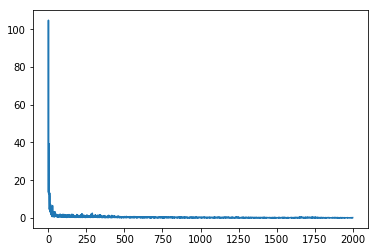

In [19]:
%%time

torch.manual_seed(0)
np.random.seed(0)

num_epochs = 100
batch_size = 5
opt = torch.optim.Adam(model_g.parameters(), lr=0.001)

losses = []
epoch_pbar = tqdm(range(num_epochs), desc='Epochs')

model_g = model_g.train()
for epoch_idx in epoch_pbar:
    all_batch_indices = util.get_batch_indices(np.arange(len(audiossds_test)), batch_size)
    batch_pbar = tqdm(all_batch_indices, desc=f'Epoch {epoch_idx} Batches')
    for batch_idxs in batch_pbar:
        X_batch, Y_batch = audiossds_train[batch_idxs]
        X_batch, Y_batch = audionnio.audio_to_nn_input(X_batch), audionnio.audio_to_nn_output(Y_batch)
        X_batch, X_batch_phase = X_batch
        X_batch, Y_batch = X_batch.to(device, dtype), Y_batch.to(device, dtype)

        opt.zero_grad()
        Y_batch_pred = model_g(X_batch)
        loss = generator_loss_function_base(Y_batch_pred, Y_batch, X_batch)
        loss.backward()
        opt.step()

        loss = loss.item()
        losses.append(loss)
        batch_pbar.set_postfix({'Loss':loss})
model_g = model_g.eval()

plt.plot(np.arange(len(losses)), losses)

del X_batch, Y_batch, Y_batch_pred, loss, losses

In [20]:
util.clear_mem(True)

total:  11.996954624
cached:  0.044040192
allocated:  0.011822592


In [21]:
with torch.no_grad():
    Y_test_pred = model_g(X_test.to(device,dtype)).cpu()

print('Test Loss: ', generator_loss_function_base(Y_test_pred, Y_test, X_test).item())


0.049093134701251984+0.6600999236106873+0.0=0.7091930508613586
Test Loss:  0.7091930508613586


Showing example:  0
Input:


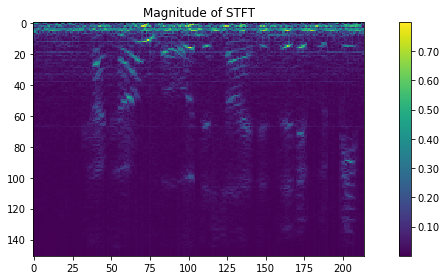

Target:


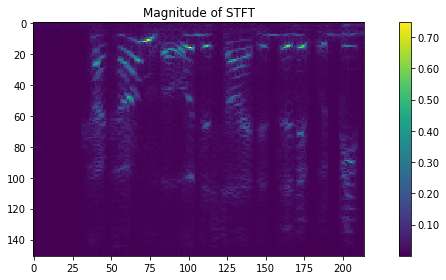

Output:


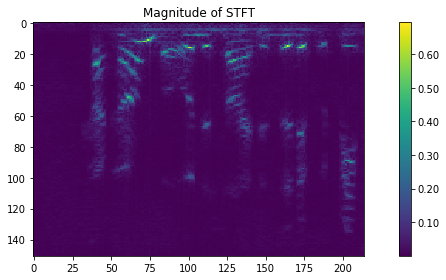

In [23]:
test_example_idx = 0
print('Showing example: ', test_example_idx)
print('Input:')
audionnio.show_play_nn_input(X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Target:')
audionnio.show_play_nn_output(Y_test, X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Output:')
audionnio.show_play_nn_output(Y_test_pred, X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)

### Save the model

In [26]:
torch.save(model_g, f'models/model_g_base_big_epochs{100}_testing_set.pth')

# Our Method

Generator-Discriminator setup (without GAN)

In [18]:
def discriminator_loss_function_base(real_out, fake_out):
    return bce(real_out, torch.ones_like(real_out)) + bce(fake_out, torch.zeros_like(fake_out))

def generator_loss_function_gan(X_batch, Y_batch, Y_batch_pred, model_d):
    Yp_batch = X_batch - Y_batch # the noise
    Yp_batch_pred = X_batch - Y_batch_pred
    
    d_Y_batch_pred = model_d(Y_batch_pred)
    d_Yp_batch_pred = model_d(Yp_batch_pred)
    
#     loss1 = mse_crit(Y_batch_pred, Y_batch)
#     loss2 = mse_crit(Yp_batch, Yp_batch_pred) # EXACT same the previous
    loss1 = 0.
    
    loss3 = bce(d_Y_batch_pred, torch.ones_like(d_Y_batch_pred))
    loss4 = bce(d_Yp_batch_pred, torch.zeros_like(d_Yp_batch_pred))
    
    total_loss = loss1+loss3+loss4
    
    return total_loss

### Training Discriminator

In [19]:
# create test set
test_set_size = 10

voice_ds.reset_next()
X_test, Y_test = generate_nn_io(batch_size=test_set_size)

print(X_test.shape)
print(Y_test.shape)

(10, 2, 129, 626)
(10, 2, 129, 626)


In [20]:
with torch.no_grad():
    Y_test_pred = model_g(to_torch(X_test))

    fake_out = model_d(Y_test_pred)
    real_out = model_d(to_torch(Y_test))

    test_loss = discriminator_loss_function_base(real_out, fake_out).item()
    accuracy = (((fake_out<0.5).sum() + (real_out>0.5).sum())/float(len(fake_out)+len(real_out))).item()

print('Test Loss: ', test_loss)
print('Accuracy: ', accuracy)


Test Loss:  1.3864991664886475
Accuracy:  0.5


In [21]:
clear_mem(True)

total:  11.996954624
cached:  0.03145728
allocated:  0.011707904


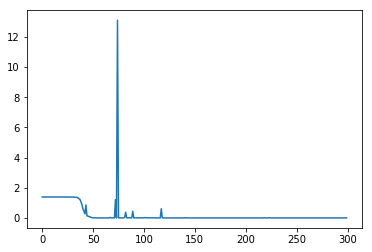

In [22]:
# %%time
model_d = model_d.train()

losses = []
batch_size = 10

batch_pbar = tqdm(range(300), desc='Batches')

for epoch in batch_pbar:
    X_batch, Y_batch = generate_nn_io(batch_size=batch_size)
    X_batch, Y_batch = to_torch(X_batch, Y_batch)
    
    with torch.no_grad():
        Y_batch_pred = model_g(X_batch)
    
    model_d.opt.zero_grad()
    real_out = model_d(Y_batch)
    fake_out = model_d(Y_batch_pred)
    loss = discriminator_loss_function_base(real_out, fake_out)
    loss.backward()
    model_d.opt.step()
    
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    batch_pbar.set_postfix({'Loss':loss})
        
plt.plot(np.arange(len(losses)), losses)

del X_batch, Y_batch, Y_batch_pred, loss, real_out, fake_out, losses


model_d = model_d.eval()

In [23]:
clear_mem(True)


total:  11.996954624
cached:  0.03145728
allocated:  0.015219712


In [24]:
with torch.no_grad():
    Y_test_pred = model_g(to_torch(X_test))

    fake_out = model_d(Y_test_pred)
    real_out = model_d(to_torch(Y_test))

    test_loss = discriminator_loss_function_base(real_out, fake_out)
    accuracy = (((fake_out<0.5).sum() + (real_out>0.5).sum())/float(len(fake_out)+len(real_out))).item()

print('Test Loss: ', test_loss)
print('Accuracy: ', accuracy)


Test Loss:  tensor(2.3175e-05, device='cuda:0')
Accuracy:  1.0


In [66]:
torch.save(model_d, 'models/disc_model.pth')

# GAN Training

In [25]:
clear_mem(True)



total:  11.996954624
cached:  0.03145728
allocated:  0.01561344


In [26]:
# %%time
model_d = model_d.train()
model_g = model_g.train()


g_losses = []
d_losses = []

batch_pbar = tqdm(range(300), desc='Batches')

batch_size = 10
for epoch in batch_pbar:
    X_batch, Y_batch = generate_nn_io(batch_size=batch_size)
    X_batch, Y_batch = to_torch(X_batch, Y_batch)
    

    # update discriminator
    model_d.opt.zero_grad()
    Y_batch_pred = model_g(X_batch)
    real_out = model_d(Y_batch)
    fake_out = model_d(Y_batch_pred)
    loss = discriminator_loss_function_base(real_out, fake_out)
    loss.backward()
    model_d.opt.step()
    
    loss = loss.item()
    d_losses.append(loss)
    batch_pbar.set_postfix({'D Loss':loss})
    
    # update generator
    model_d.opt.zero_grad()
    model_g.opt.zero_grad()
    
    Y_batch_pred = model_g(X_batch)
    loss = generator_loss_function_gan(X_batch, Y_batch, Y_batch_pred, model_d)
    loss.backward()
    model_g.opt.step()
    
    loss = loss.item()
    g_losses.append(loss)
    batch_pbar.set_postfix({'G Loss':loss})
    
del X_batch, Y_batch, Y_batch_pred, loss
    
plt.plot(np.arange(len(losses)), losses)


model_d = model_d.eval()
model_g = model_g.eval()

NameError: name 'losses' is not defined

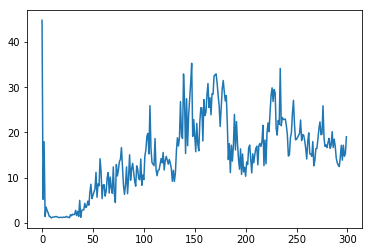

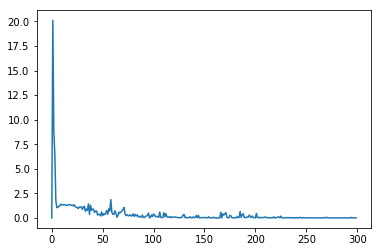

In [27]:
plt.plot(np.arange(len(g_losses)), g_losses)
plt.show()

plt.plot(np.arange(len(d_losses)), d_losses)
plt.show()



In [ ]:
clear_mem(True)

In [ ]:
show_test_example(model_g, X_test, Y_test, show_idx=0)